# CREDIT CARD SPEND PREDICTION & IDENTIFY DRIVERS FOR SPEND BY SHASHVINDU JHA # jhashashvindu@yahoo.com

#Definition of Target and Outcome Window
   One of the global banks would like to understand the factors driving credit card spend. The bank also wants to use these insights to predict credit limit for new applicants. 
Data Pre-Processing -
- Missing Values Treatment - Numerical (Mean imputation) and Categorical (mode imputation)
- Univariate Analysis - Outlier analysis
Data Exploratory Analysis
- Bivariate Analysis - Correaltion with target variable
- Variable Transformation - X_exp, X_log, X_sqrt, X_square
- Variable Reduction - VIF, SelectKBest, PCA
Model Build and Model Evaluation
- Train and Test split
- Significance of each Variable
- Model used :- OLS, Linear Regression, Support Vector Regressor, Random Forest Regressor, Gradient Boosting Regressor,
                Lasso Regressor, K Neighbors Regressor, XGB Regressor
- Testing Parameters:- MAE(Mean Absolute Error), MSE(Mean Square Error), RMSE(Root Mean Square Error), 
- Scoring:- R2, cross_val_score
Model Interpretation for its properties
- Inferencing for finding the most important contributors

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas_profiling as pp
from matplotlib.backends.backend_pdf import PdfPages
import statistics as st
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
%matplotlib inline
import pandas_profiling

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create UDFs

In [3]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [6]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [7]:
#Read data
credit = pd.read_excel("Data Set.xlsx")
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [8]:
credit.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [9]:
# set column ''custid'' as the index of the Dataframe
#credit = credit.set_index('custid')
#credit

In [10]:
#pandas_profiling.ProfileReport(credit)

In [11]:
# new target variable created after merging variables with same properties.
credit['total_spend'] = credit['cardspent'] + credit['card2spent']


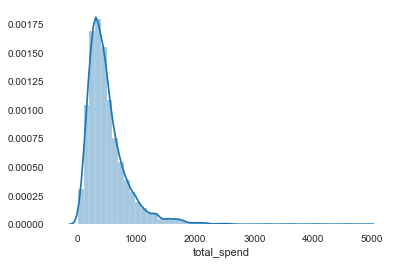

In [12]:
#Visualizing distribution of total_spend
sb.distplot(credit['total_spend'])

In [13]:
credit.total_spend.skew()

2.707546987697521

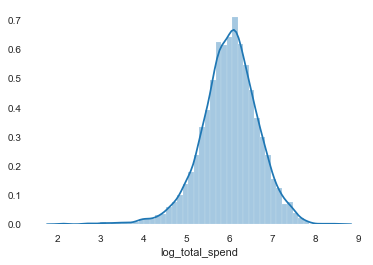

In [14]:
#log target taken to normalize the data.
credit['log_total_spend'] = np.log(credit['total_spend']) 
#Visualizing log_total_spend
sb.distplot(credit['log_total_spend'])

In [15]:
credit.log_total_spend.skew()

-0.539836787814146

In [16]:
# Creating Categorical List= Contains categorical variables...

for x in [
"region","townsize","gender","agecat","birthmonth","edcat","jobcat","union","employ","empcat","retire","inccat","default","jobsat","marital","spousedcat","homeown","hometype","address","addresscat","cars","carown","cartype","carcatvalue","carbought","carbuy","commute","commutecat","commutecar","commutemotorcycle","commutecarpool","commutebus","commuterail","commutepublic","commutebike","commutewalk","commutenonmotor","telecommute","reason","polview","polparty","polcontrib","vote","card","cardtype","cardbenefit","cardfee","cardtenure","cardtenurecat","card2","card2type","card2benefit","card2fee","card2tenure","card2tenurecat","active","bfast","churn","tollfree","equip","callcard","wireless","multline","voice","pager","internet","callid","callwait","forward","confer","ebill","owntv","ownvcr","owndvd","owncd","ownpda","ownpc","ownipod","owngame","ownfax","news","response_01","response_02","response_03"
]:
    credit[x]=credit[x].astype('object')

In [17]:
#drop column which have more than 25% missing value + "cardspent","card2spent"
#credit.drop(["cardspent","card2spent","lntollmon","lntollten","lnequipmon","lnequipten","lncardmon","lncardten","lnwiremon","lnwireten"],axis=1, inplace=True)

In [18]:
 #Remove log variables and categorical variables with numerical featuresmore than 25% missing value + "cardspent","card2spent"
    # Dropping columns with high percentage of zeros
credit.drop(columns=["custid","lninc","lncreddebt","lnothdebt","lnlongmon","lnlongten","lntollmon","lntollten","lnequipmon",
                     "lnequipten","lncardmon","lncardten","lnwiremon","lnwireten","address","cars","cardtenure",
                     "card2tenure","cardmon","cardten","equipmon","equipten","pets","pets_birds","pets_cats","pets_dogs",
                     "pets_freshfish","pets_reptiles","pets_saltfish","pets_small","tollmon","tollten","wiremon","wireten"],
            axis=1, inplace=True) 


In [19]:
credit 

,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,total_spend,log_total_spend
0,1,2,1,20,2,September,15,3,1,1,...,0,1,1,0,0,0,1,0,149.46,5.007029
1,5,5,0,22,2,May,17,4,2,0,...,1,1,1,1,1,0,0,0,77.54,4.350794
2,3,4,1,67,6,June,14,2,2,0,...,0,0,0,0,1,0,0,0,359.97,5.886021
3,4,3,0,23,2,May,16,3,2,0,...,1,1,1,0,1,1,0,0,359.41,5.884464
4,2,2,0,26,3,July,16,3,2,0,...,1,0,1,0,0,0,1,0,507.83,6.230147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,2,0,68,6,January,10,1,1,0,...,0,0,0,0,1,0,0,0,1425.67,7.262397
4996,3,3,0,51,5,May,14,2,1,0,...,0,0,0,0,0,0,0,0,366.35,5.903589
4997,4,5,0,75,6,August,17,4,1,0,...,0,0,0,0,1,0,0,0,1527.75,7.331551
4998,1,1,0,47,4,December,19,4,2,0,...,1,1,1,0,1,0,0,0,752.95,6.623999


In [20]:
credit

,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,total_spend,log_total_spend
0,1,2,1,20,2,September,15,3,1,1,...,0,1,1,0,0,0,1,0,149.46,5.007029
1,5,5,0,22,2,May,17,4,2,0,...,1,1,1,1,1,0,0,0,77.54,4.350794
2,3,4,1,67,6,June,14,2,2,0,...,0,0,0,0,1,0,0,0,359.97,5.886021
3,4,3,0,23,2,May,16,3,2,0,...,1,1,1,0,1,1,0,0,359.41,5.884464
4,2,2,0,26,3,July,16,3,2,0,...,1,0,1,0,0,0,1,0,507.83,6.230147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,2,0,68,6,January,10,1,1,0,...,0,0,0,0,1,0,0,0,1425.67,7.262397
4996,3,3,0,51,5,May,14,2,1,0,...,0,0,0,0,0,0,0,0,366.35,5.903589
4997,4,5,0,75,6,August,17,4,1,0,...,0,0,0,0,1,0,0,0,1527.75,7.331551
4998,1,1,0,47,4,December,19,4,2,0,...,1,1,1,0,1,0,0,0,752.95,6.623999


In [21]:
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(credit.dtypes) if dict(credit.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(credit.dtypes) if dict(credit.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['age', 'ed', 'income', 'debtinc', 'creddebt', 'othdebt', 'spoused', 'reside', 'carvalue', 'commutetime', 'cardspent', 'card2spent', 'tenure', 'longmon', 'longten', 'hourstv', 'total_spend', 'log_total_spend']
['region', 'townsize', 'gender', 'agecat', 'birthmonth', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'inccat', 'default', 'jobsat', 'marital', 'spousedcat', 'homeown', 'hometype', 'addresscat', 'carown', 'cartype', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenurecat', 'active', 'bfast', 'churn', 'tollfree', 'equip', 'callcard', 'wireless', 'multline', 'voice', 'pager', 'internet', 'callid', 'callwait', 'forward', '

In [22]:
#Convert a list in to dataframe
#Information about numericvariable in custdata_df
credit_num=credit[numeric_var_names]
credit_num

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,cardspent,card2spent,tenure,longmon,longten,hourstv,total_spend,log_total_spend
0,20,15,31,11.1,1.200909,2.240091,-1,3,14.3,22.0,81.66,67.80,5,6.50,34.40,13,149.46,5.007029
1,22,17,15,18.6,1.222020,1.567980,-1,2,6.8,29.0,42.60,34.94,39,8.90,330.60,18,77.54,4.350794
2,67,14,35,9.9,0.928620,2.536380,13,3,18.8,24.0,184.22,175.75,65,28.40,1858.35,21,359.97,5.886021
3,23,16,20,5.7,0.022800,1.117200,18,5,8.7,38.0,340.99,18.42,36,6.00,199.45,26,359.41,5.884464
4,26,16,23,1.7,0.214659,0.176341,13,4,10.6,32.0,255.10,252.73,21,3.05,74.10,27,507.83,6.230147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,68,10,196,8.0,7.934080,7.745920,-1,1,64.5,21.0,872.11,553.56,69,34.10,2405.90,19,1425.67,7.262397
4996,51,14,83,15.0,3.336600,9.113400,-1,1,40.0,26.0,210.81,155.54,30,10.40,289.00,14,366.35,5.903589
4997,75,17,108,10.8,3.557520,8.106480,-1,1,53.6,32.0,884.08,643.67,72,29.40,2109.25,16,1527.75,7.331551
4998,47,19,189,10.8,5.021352,15.390648,15,4,96.0,12.0,381.35,371.60,37,7.95,282.70,24,752.95,6.623999


In [23]:
credit_cat=credit[cat_var_names]
credit_cat

,region,townsize,gender,agecat,birthmonth,edcat,jobcat,union,employ,empcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,2,1,2,September,3,1,1,0,1,...,0,0,0,1,1,0,0,0,1,0
1,5,5,0,2,May,4,2,0,0,1,...,1,1,1,1,1,1,1,0,0,0
2,3,4,1,6,June,2,2,0,16,5,...,1,0,0,0,0,0,1,0,0,0
3,4,3,0,2,May,3,2,0,0,1,...,1,0,1,1,1,0,1,1,0,0
4,2,2,0,3,July,3,2,0,1,1,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,2,0,6,January,1,1,0,24,5,...,1,0,0,0,0,0,1,0,0,0
4996,3,3,0,5,May,2,1,0,6,3,...,1,0,0,0,0,0,0,0,0,0
4997,4,5,0,6,August,4,1,0,24,5,...,1,1,0,0,0,0,1,0,0,0
4998,1,1,0,4,December,4,2,0,3,2,...,1,0,1,1,1,0,1,0,0,0


# Numerical Features

# Creating Data audit Report

In [24]:

credit_num.apply(lambda x: continuous_var_summary(x))

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,cardspent,card2spent,tenure,longmon,longten,hourstv,total_spend,log_total_spend
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4998.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,4.997000e+03,5000.000000,5.000000e+03,5000.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000e+00,0.000000
SUM,235128.000000,72715.000000,273798.000000,49770.800000,9286.628229,18272.300771,30564.000000,11020.000000,116162.900000,126677.000000,1.686013e+06,804380.550000,191024.000000,67357.250000,3.542232e+06,98225.000000,2.490393e+06,30006.220213
MEAN,47.025600,14.543000,54.759600,9.954160,1.857326,3.654460,6.112800,2.204000,23.232580,25.345538,3.372025e+02,160.876110,38.204800,13.471450,7.088718e+02,19.645000,4.980786e+02,6.001244
MEDIAN,47.000000,14.000000,38.000000,8.800000,0.926437,2.098540,-1.000000,2.000000,17.000000,25.000000,2.763600e+02,125.340000,38.000000,9.550000,3.500000e+02,20.000000,4.142500e+02,6.026470
STD,17.770338,3.281083,55.377511,6.399783,3.415732,5.395172,7.743518,1.393977,21.231637,5.879149,2.451451e+02,146.292771,22.661888,12.773381,9.792911e+02,5.165609,3.515293e+02,0.671473
VAR,315.784902,10.765504,3066.668742,40.957226,11.667225,29.107876,59.962069,1.943173,450.782397,34.564390,6.009610e+04,21401.574779,513.561169,163.159266,9.590110e+05,26.683512,1.235728e+05,0.450876
MIN,18.000000,6.000000,9.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,-1.000000,8.000000,0.000000e+00,0.000000,0.000000,0.900000,9.000000e-01,0.000000,8.110000e+00,2.093098
P1,18.000000,8.000000,9.000000,0.700000,0.033160,0.114299,-1.000000,1.000000,-1.000000,13.000000,4.081950e+01,0.000000,1.000000,1.850000,2.400000e+00,0.000000,5.819760e+01,4.063844
P5,20.000000,9.000000,13.000000,1.900000,0.101088,0.287692,-1.000000,1.000000,-1.000000,16.000000,9.130450e+01,14.819500,4.000000,2.900000,1.262000e+01,12.000000,1.331060e+02,4.891146


In [25]:
#spoused and carvalue have value -1 converting them to 0

In [26]:
credit_num.carvalue.replace(to_replace=-1,value=0,inplace=True)
credit_num.apply(lambda x: continuous_var_summary(x))

c:\python3.7\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,cardspent,card2spent,tenure,longmon,longten,hourstv,total_spend,log_total_spend
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4998.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,4.997000e+03,5000.000000,5.000000e+03,5000.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000e+00,0.000000
SUM,235128.000000,72715.000000,273798.000000,49770.800000,9286.628229,18272.300771,30564.000000,11020.000000,116659.900000,126677.000000,1.686013e+06,804380.550000,191024.000000,67357.250000,3.542232e+06,98225.000000,2.490393e+06,30006.220213
MEAN,47.025600,14.543000,54.759600,9.954160,1.857326,3.654460,6.112800,2.204000,23.331980,25.345538,3.372025e+02,160.876110,38.204800,13.471450,7.088718e+02,19.645000,4.980786e+02,6.001244
MEDIAN,47.000000,14.000000,38.000000,8.800000,0.926437,2.098540,-1.000000,2.000000,17.000000,25.000000,2.763600e+02,125.340000,38.000000,9.550000,3.500000e+02,20.000000,4.142500e+02,6.026470
STD,17.770338,3.281083,55.377511,6.399783,3.415732,5.395172,7.743518,1.393977,21.119979,5.879149,2.451451e+02,146.292771,22.661888,12.773381,9.792911e+02,5.165609,3.515293e+02,0.671473
VAR,315.784902,10.765504,3066.668742,40.957226,11.667225,29.107876,59.962069,1.943173,446.053534,34.564390,6.009610e+04,21401.574779,513.561169,163.159266,9.590110e+05,26.683512,1.235728e+05,0.450876
MIN,18.000000,6.000000,9.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,8.000000,0.000000e+00,0.000000,0.000000,0.900000,9.000000e-01,0.000000,8.110000e+00,2.093098
P1,18.000000,8.000000,9.000000,0.700000,0.033160,0.114299,-1.000000,1.000000,0.000000,13.000000,4.081950e+01,0.000000,1.000000,1.850000,2.400000e+00,0.000000,5.819760e+01,4.063844
P5,20.000000,9.000000,13.000000,1.900000,0.101088,0.287692,-1.000000,1.000000,0.000000,16.000000,9.130450e+01,14.819500,4.000000,2.900000,1.262000e+01,12.000000,1.331060e+02,4.891146


In [27]:
credit_num.spoused.replace(to_replace=-1,value=0,inplace=True)
num_summary=credit_num.apply(lambda x: continuous_var_summary(x))
num_summary

c:\python3.7\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,cardspent,card2spent,tenure,longmon,longten,hourstv,total_spend,log_total_spend
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4998.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,4.997000e+03,5000.000000,5.000000e+03,5000.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000e+00,0.000000
SUM,235128.000000,72715.000000,273798.000000,49770.800000,9286.628229,18272.300771,33163.000000,11020.000000,116659.900000,126677.000000,1.686013e+06,804380.550000,191024.000000,67357.250000,3.542232e+06,98225.000000,2.490393e+06,30006.220213
MEAN,47.025600,14.543000,54.759600,9.954160,1.857326,3.654460,6.632600,2.204000,23.331980,25.345538,3.372025e+02,160.876110,38.204800,13.471450,7.088718e+02,19.645000,4.980786e+02,6.001244
MEDIAN,47.000000,14.000000,38.000000,8.800000,0.926437,2.098540,0.000000,2.000000,17.000000,25.000000,2.763600e+02,125.340000,38.000000,9.550000,3.500000e+02,20.000000,4.142500e+02,6.026470
STD,17.770338,3.281083,55.377511,6.399783,3.415732,5.395172,7.267447,1.393977,21.119979,5.879149,2.451451e+02,146.292771,22.661888,12.773381,9.792911e+02,5.165609,3.515293e+02,0.671473
VAR,315.784902,10.765504,3066.668742,40.957226,11.667225,29.107876,52.815780,1.943173,446.053534,34.564390,6.009610e+04,21401.574779,513.561169,163.159266,9.590110e+05,26.683512,1.235728e+05,0.450876
MIN,18.000000,6.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000e+00,0.000000,0.000000,0.900000,9.000000e-01,0.000000,8.110000e+00,2.093098
P1,18.000000,8.000000,9.000000,0.700000,0.033160,0.114299,0.000000,1.000000,0.000000,13.000000,4.081950e+01,0.000000,1.000000,1.850000,2.400000e+00,0.000000,5.819760e+01,4.063844
P5,20.000000,9.000000,13.000000,1.900000,0.101088,0.287692,0.000000,1.000000,0.000000,16.000000,9.130450e+01,14.819500,4.000000,2.900000,1.262000e+01,12.000000,1.331060e+02,4.891146


# Visualzing outliers for numerical features

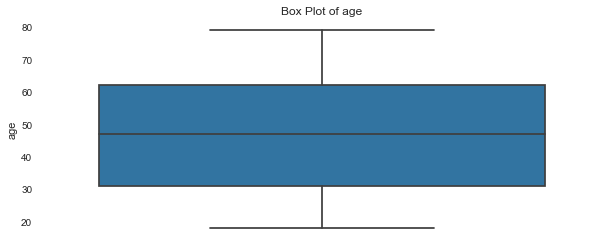

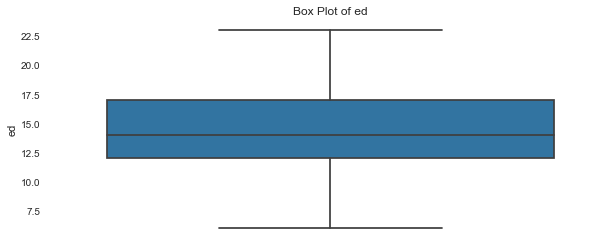

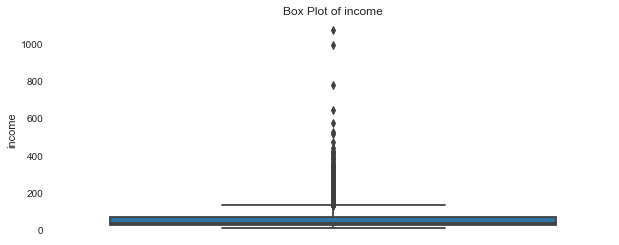

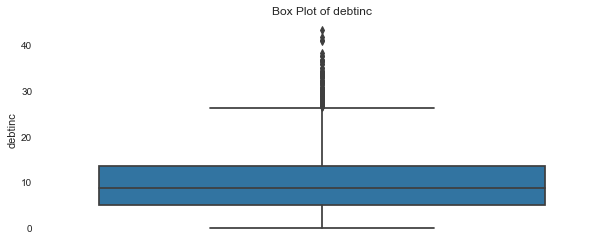

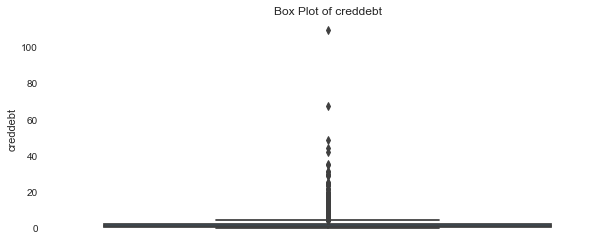

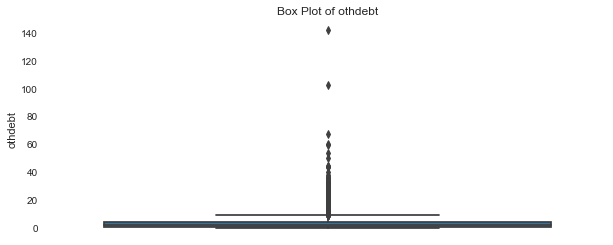

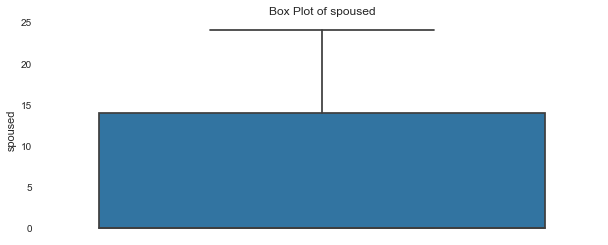

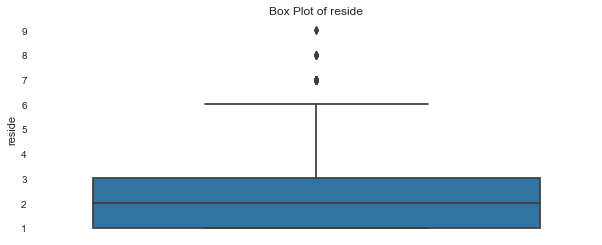

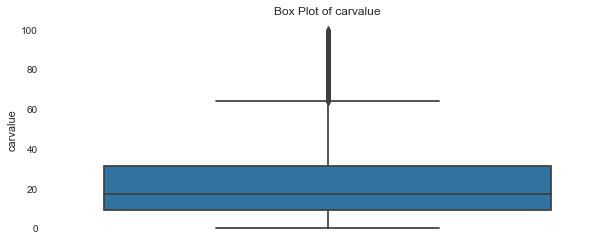

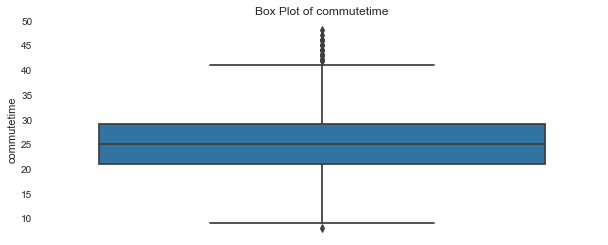

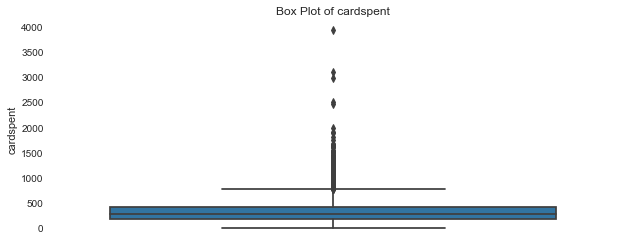

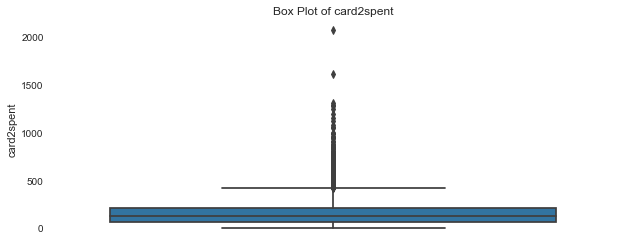

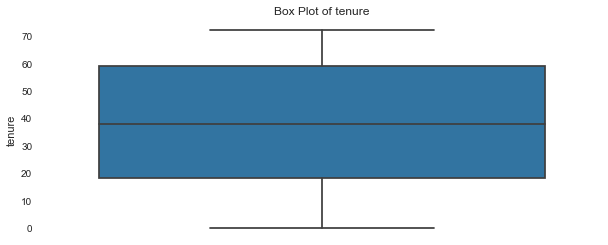

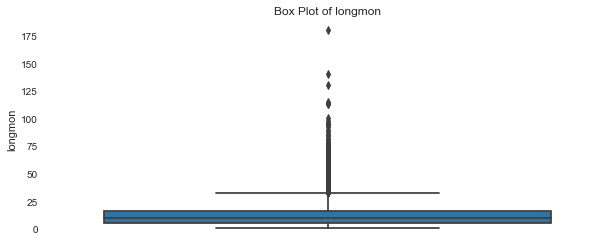

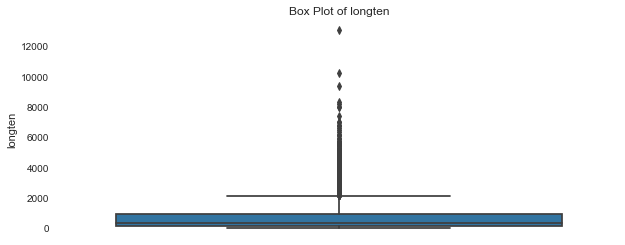

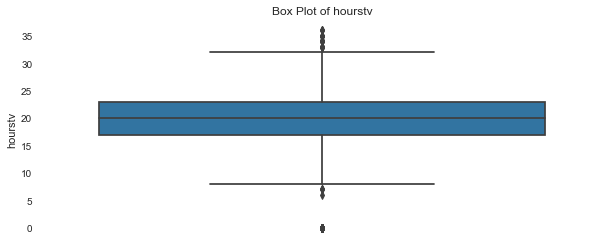

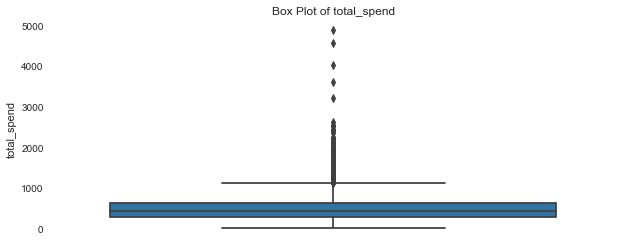

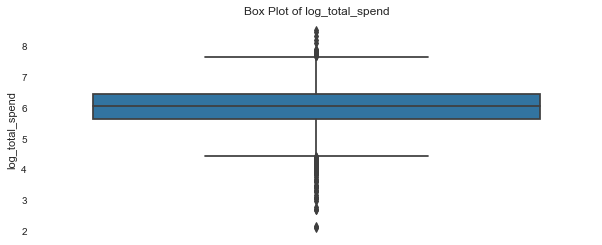

In [28]:
bp = PdfPages('BoxPlots for outlier detection.pdf')
for num_variable in credit_num.columns:
    fig,axes = plt.subplots(figsize=(10,4))
    sb.boxplot(y=num_variable, data = credit_num)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

# catagorical value

In [29]:
credit_cat=credit[cat_var_names]
credit_cat.head(5)

,region,townsize,gender,agecat,birthmonth,edcat,jobcat,union,employ,empcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,2,1,2,September,3,1,1,0,1,...,0,0,0,1,1,0,0,0,1,0
1,5,5,0,2,May,4,2,0,0,1,...,1,1,1,1,1,1,1,0,0,0
2,3,4,1,6,June,2,2,0,16,5,...,1,0,0,0,0,0,1,0,0,0
3,4,3,0,2,May,3,2,0,0,1,...,1,0,1,1,1,0,1,1,0,0
4,2,2,0,3,July,3,2,0,1,1,...,1,0,1,0,1,0,0,0,1,0


In [30]:
cat_summary=credit_cat.apply(lambda x: categorical_var_summary(x)).T

#cat_summary.to_csv('cat_summary.csv',header = True,index= True)
cat_summary

,N,NMISS,MODE,FREQ,PERCENT
region,5000,0,5,1027,20.54
townsize,4998,2,1,1436,28.73
gender,5000,0,1,2518,50.36
agecat,5000,0,4,1222,24.44
birthmonth,5000,0,September,458,9.16
...,...,...,...,...,...
ownfax,5000,0,0,4106,82.12
news,5000,0,0,2637,52.74
response_01,5000,0,0,4582,91.64
response_02,5000,0,0,4351,87.02


In [31]:
def cat_uni(x):
    return pd.Series([x.unique()],index=['UniqueValues'])

In [32]:
cat_unique=credit_cat.apply(lambda x: cat_uni(x)).T
cat_unique

,UniqueValues
region,"[1, 5, 3, 4, 2]"
townsize,"[2.0, 5.0, 4.0, 3.0, 1.0, nan]"
gender,"[1, 0]"
agecat,"[2, 6, 3, 5, 4]"
birthmonth,"[September, May, June, July, August, October, ..."
...,...
ownfax,"[0, 1]"
news,"[0, 1]"
response_01,"[0, 1]"
response_02,"[1, 0]"


# Handling Outliers

In [33]:
#Handling Outliers for numerical data - Through function
credit_num = credit_num.apply(lambda x: x.clip(lower = x.quantile(0.05),
                                               upper = x.quantile(0.95)))

In [34]:
num_summary=credit_num.apply(lambda x: continuous_var_summary(x))
num_summary

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,cardspent,card2spent,tenure,longmon,longten,hourstv,total_spend,log_total_spend
N,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4998.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,4.997000e+03,5000.000000,5.000000e+03,5000.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000e+00,0.000000
SUM,234988.000000,72719.000000,254410.000000,48824.800000,7879.788354,16077.817734,32776.000000,10834.000000,113249.300000,126247.000000,1.619411e+06,760281.805000,191489.000000,63036.625000,3.211367e+06,99011.000000,2.396244e+06,30060.613192
MEAN,46.997600,14.543800,50.882000,9.764960,1.575958,3.215564,6.555200,2.166800,22.649860,25.259504,3.238822e+02,152.056361,38.297800,12.607325,6.426589e+02,19.802200,4.792489e+02,6.012123
MEDIAN,47.000000,14.000000,38.000000,8.800000,0.926437,2.098540,0.000000,2.000000,17.000000,25.000000,2.763600e+02,125.340000,38.000000,9.550000,3.500000e+02,20.000000,4.142500e+02,6.026470
STD,17.531739,3.131843,36.728472,5.738747,1.688276,3.104157,7.130015,1.292947,19.170884,5.310801,1.860671e+02,110.771827,22.515997,9.222441,7.193469e+02,4.300927,2.719719e+02,0.576824
VAR,307.361867,9.808443,1348.980672,32.933223,2.850276,9.635791,50.837120,1.671712,367.522777,28.204607,3.462097e+04,12270.397572,506.970109,85.053425,5.174600e+05,18.497975,7.396873e+04,0.332726
MIN,20.000000,9.000000,13.000000,1.900000,0.101088,0.287692,0.000000,1.000000,0.000000,16.000000,9.130450e+01,14.819500,4.000000,2.900000,1.262000e+01,12.000000,1.331060e+02,4.891146
P1,20.000000,9.000000,13.000000,1.900000,0.101088,0.287692,0.000000,1.000000,0.000000,16.000000,9.130450e+01,14.819500,4.000000,2.900000,1.262000e+01,12.000000,1.331060e+02,4.891146
P5,20.000000,9.000000,13.000000,1.900000,0.101088,0.287728,0.000000,1.000000,0.000000,16.000000,9.130973e+01,14.819975,4.000000,2.900000,1.264400e+01,12.000000,1.331098e+02,4.891174


# Reviewing if all outliers have been fixed

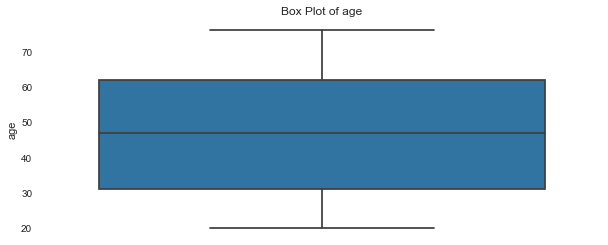

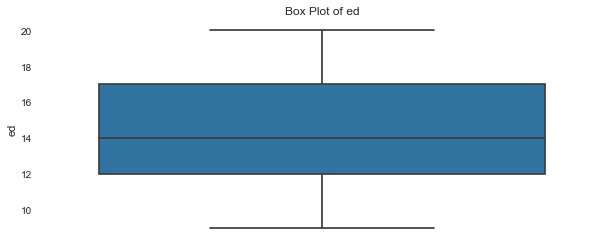

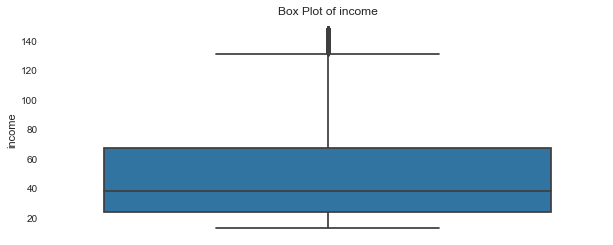

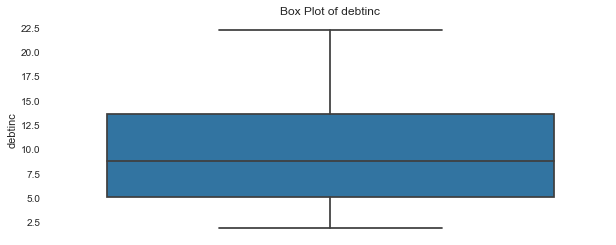

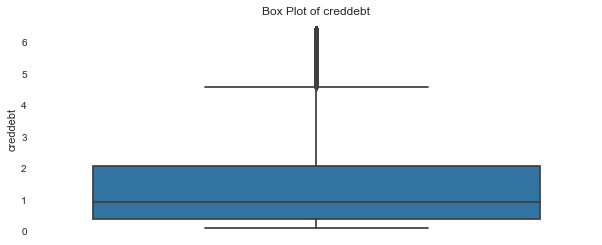

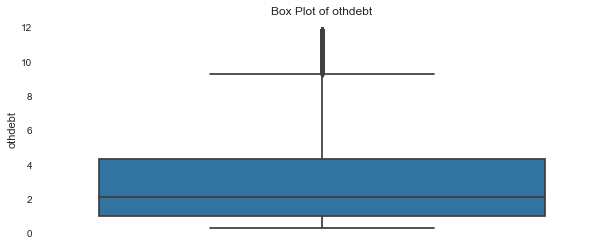

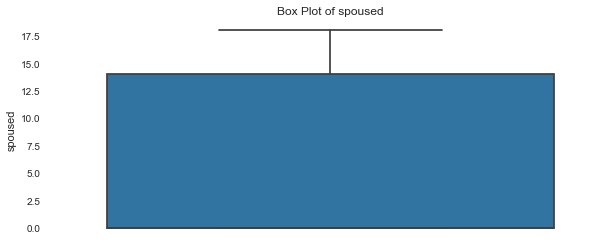

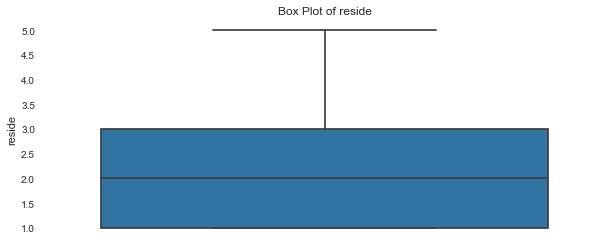

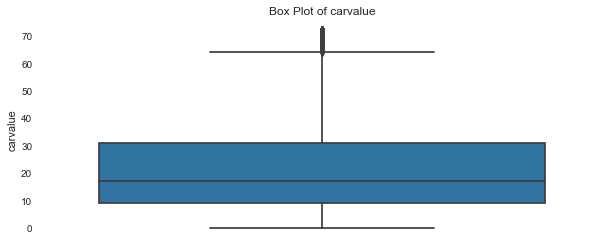

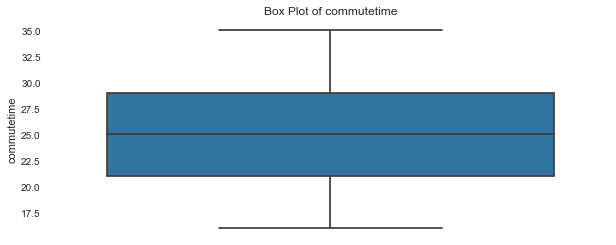

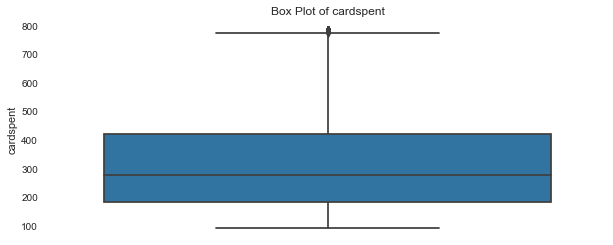

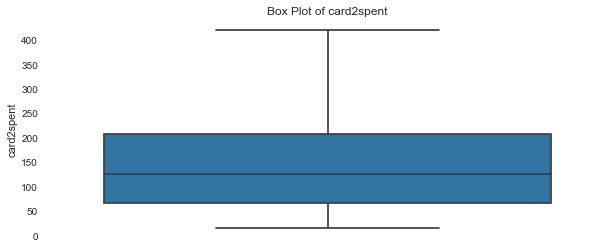

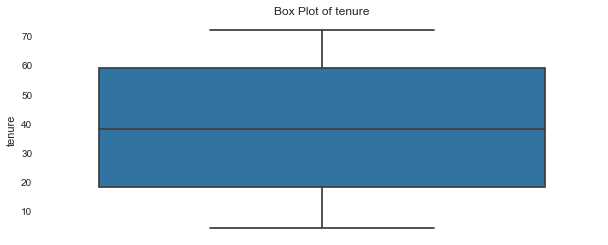

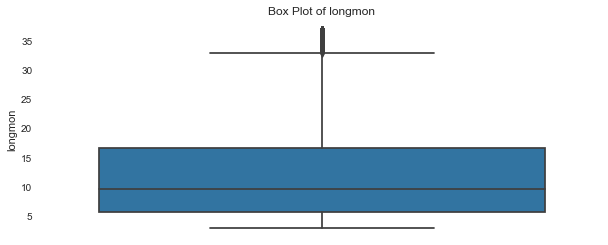

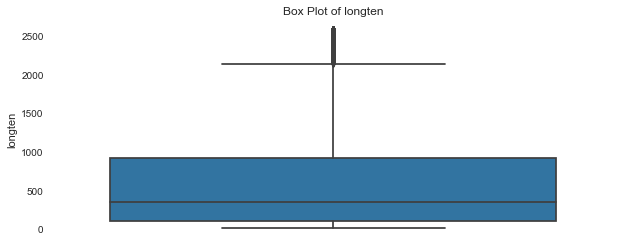

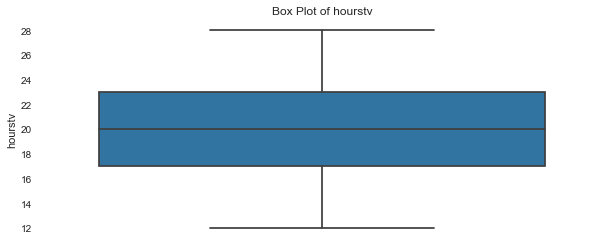

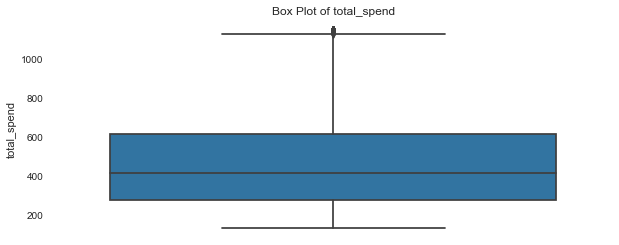

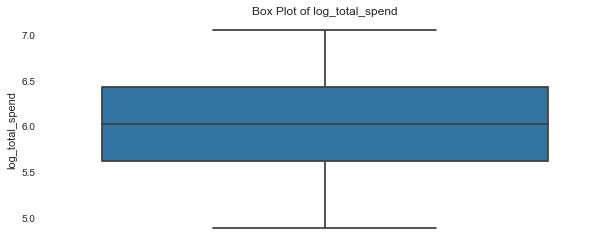

In [35]:

bp = PdfPages('BoxPlots for outlier detection 2.pdf')

for num_variable in credit_num.columns:
    fig,axes = plt.subplots(figsize=(10,4))
    sb.boxplot(y=num_variable, data = credit_num)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

# Handling Missing Values

In [36]:
credit_num.isna().sum() * 100 / credit_num.isna().count()

age                0.00
ed                 0.00
income             0.00
debtinc            0.00
creddebt           0.00
othdebt            0.00
spoused            0.00
reside             0.00
carvalue           0.00
commutetime        0.04
cardspent          0.00
card2spent         0.00
tenure             0.00
longmon            0.00
longten            0.06
hourstv            0.00
total_spend        0.00
log_total_spend    0.00
dtype: float64

In [37]:
credit_cat.isna().sum() * 100 / credit_cat.isna().count()

region         0.00
townsize       0.04
gender         0.00
agecat         0.00
birthmonth     0.00
               ... 
ownfax         0.00
news           0.00
response_01    0.00
response_02    0.00
response_03    0.00
Length: 80, dtype: float64

In [38]:
credit_num= credit_num.apply(missing_imputation)
credit_cat = credit_cat.apply(missing_imputation)

# Again check missing values has been treated or no

In [39]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data : ", credit_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data : ", credit_cat.isnull().sum().values.sum())


Missing values in numerical data :  0

Missing values in categorical data :  2


In [40]:
#Handling missings - by Function (Makethe function to treat all data in one shot)
def Missing_imputation_mode(x):
    x = x.fillna(x.mode())
    return x
credit_cat = credit_cat.apply(lambda x: Missing_imputation_mode(x))

In [41]:
print ("\nMissing values in categorical data : ", credit_cat.isnull().sum().values.sum())


Missing values in categorical data :  2


# now checking individually

In [42]:
credit_cat.isna().sum() * 100 / credit_cat.isna().count()

region         0.00
townsize       0.04
gender         0.00
agecat         0.00
birthmonth     0.00
               ... 
ownfax         0.00
news           0.00
response_01    0.00
response_02    0.00
response_03    0.00
Length: 80, dtype: float64

In [43]:
credit_cat['townsize'] = credit_cat['townsize'].fillna(credit_cat['townsize'].mode()[0])

In [44]:
print ("\nMissing values in categorical data : ", credit_cat.isnull().sum().values.sum())


Missing values in categorical data :  0


# Numerical variables are being tranfomred to different types ( X(default), X_squared(squared), X_sqrt(squareroot), X_ln(log), X_exp(exponential)) to check which type correlates better with target variable

In [45]:
def check_transformation(df,target):
    squared = (df**2).add_suffix("_squared") #squared
    square_root = (df**0.5).add_suffix("_sqrt") #square root
    natural_log = np.log(df+1).add_suffix("_ln") #log 
    exp = np.exp(df).add_suffix("_exp") # exponent
    
    transform_squared = pd.concat([df, squared], axis=1) #concatenating all newly created variables
    transform_squared.drop(columns=[str(target)+'_squared'],axis=1,inplace=True) #dropping conversions of target variables.
    
    transform_square_root = pd.concat([df, square_root], axis=1) #concatenating all newly created variables
    transform_square_root.drop(columns=[str(target)+'_sqrt'],axis=1,inplace=True) #dropping conversions of target variables.
    
    transform_natural_log = pd.concat([df, natural_log], axis=1) #concatenating all newly created variables
    transform_natural_log.drop(columns=[str(target)+'_ln'],axis=1,inplace=True) #dropping conversions of target variables.
    
    transform_exp = pd.concat([df, exp], axis=1) #concatenating all newly created variables
    transform_exp.drop(columns=[str(target)+'_exp'],axis=1,inplace=True) #dropping conversions of target variables.
    
    complete_transform = pd.concat([df, squared, square_root, natural_log, exp], axis=1) #concatenating all newly created variables
    complete_transform.drop(columns=[str(target)+'_squared', str(target)+'_sqrt', str(target)+'_ln', str(target)+'_exp'],axis=1,inplace=True)
    #dropping conversions of target variables. 
        
    return transform_squared, transform_square_root, transform_natural_log, transform_exp, complete_transform
    
def corr_plot(data,target):
    q=data.corr()
    q = pd.DataFrame(q[str(target)])
    q.reset_index(inplace=True)
    q.columns = ['columns','row_value']
    plt.figure(figsize=(15,15))
    q.sort_values(by=['columns'],ascending=False,inplace=True)
    plt.barh(q['columns'],width=q['row_value'],align='center',color=['r','g'],)

In [46]:
a,b,c,d,e=check_transformation(credit_num,'log_total_spend')

c:\python3.7\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


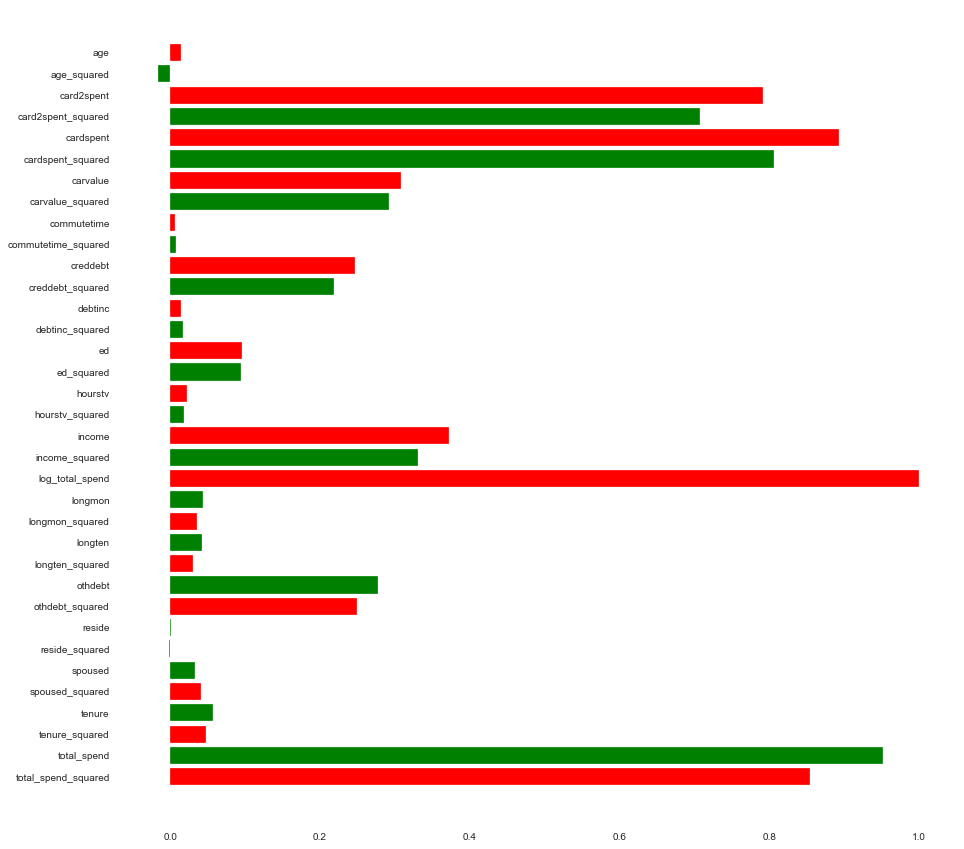

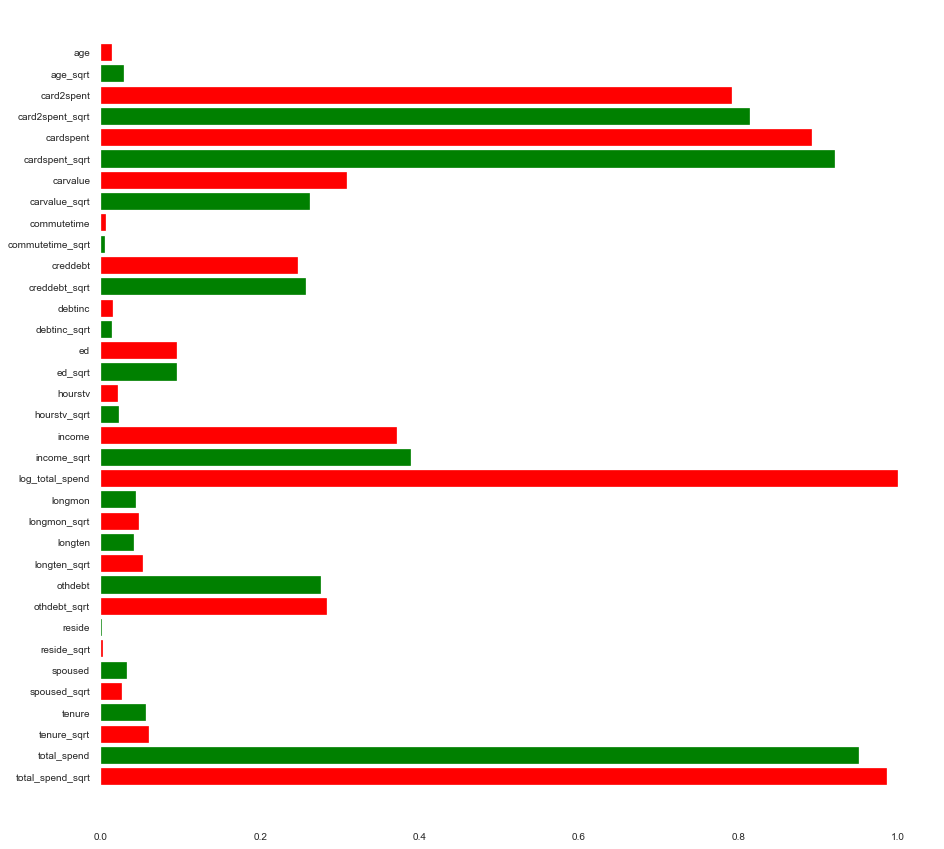

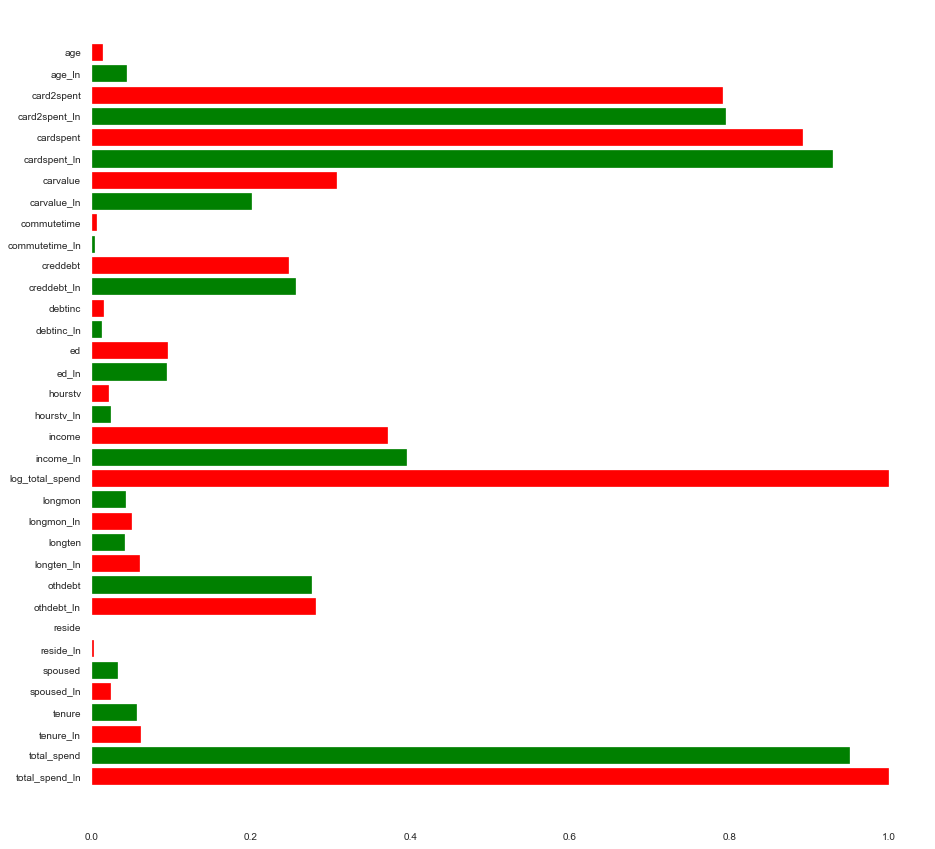

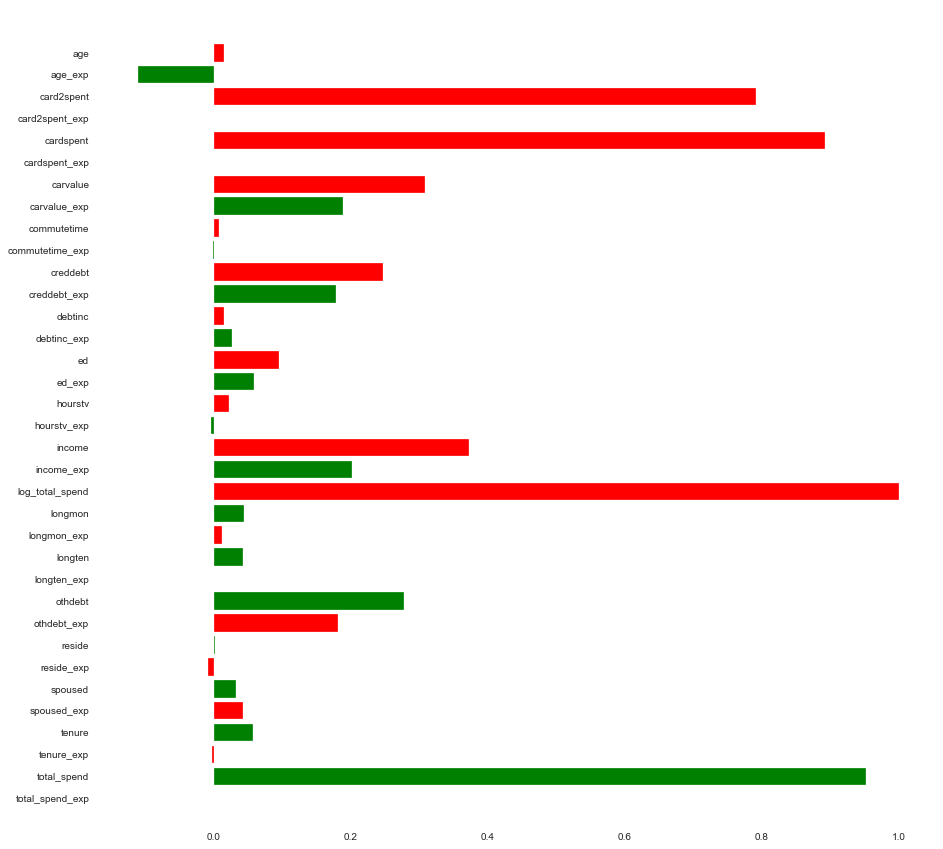

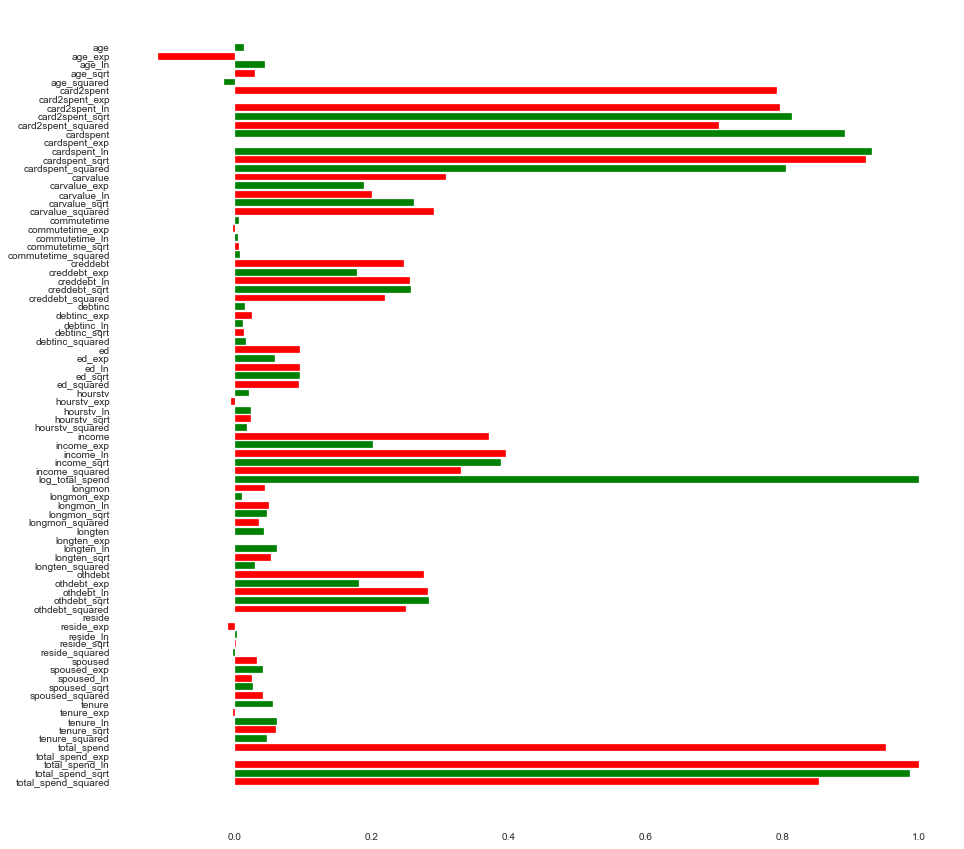

In [47]:
corr_plot(a,'log_total_spend')
corr_plot(b,'log_total_spend')
corr_plot(c,'log_total_spend')
corr_plot(d,'log_total_spend')
corr_plot(e,'log_total_spend')

In [48]:
# for c_feature in categorical_features
for c_feature in credit_cat.columns:
    credit_cat[c_feature] = credit_cat[c_feature].astype('category')
    credit_cat = create_dummies(credit_cat, c_feature)
      

In [49]:
credit_cat

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,0,1,1,0,0
4,1,0,0,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4996,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4997,0,0,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,0,0,0


# Merge Numerical and categorical data

In [50]:
credit_new = pd.concat([credit_num,credit_cat], axis=1)

In [51]:
credit_new.shape

(5000, 240)

In [52]:
credit_new

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,20,15,31,11.1,1.200909,2.240091,0,3,14.3,22.0,...,0,0,0,1,1,0,0,0,1,0
1,22,17,15,18.6,1.222020,1.567980,0,2,6.8,29.0,...,1,1,1,1,1,1,1,0,0,0
2,67,14,35,9.9,0.928620,2.536380,13,3,18.8,24.0,...,1,0,0,0,0,0,1,0,0,0
3,23,16,20,5.7,0.101088,1.117200,18,5,8.7,35.0,...,1,0,1,1,1,0,1,1,0,0
4,26,16,23,1.9,0.214659,0.287692,13,4,10.6,32.0,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,68,10,147,8.0,6.373010,7.745920,0,1,64.5,21.0,...,1,0,0,0,0,0,1,0,0,0
4996,51,14,83,15.0,3.336600,9.113400,0,1,40.0,26.0,...,1,0,0,0,0,0,0,0,0,0
4997,75,17,108,10.8,3.557520,8.106480,0,1,53.6,32.0,...,1,1,0,0,0,0,1,0,0,0
4998,47,19,147,10.8,5.021352,11.815981,15,4,72.0,16.0,...,1,0,1,1,1,0,1,0,0,0


# Explore data and check the variable distribution

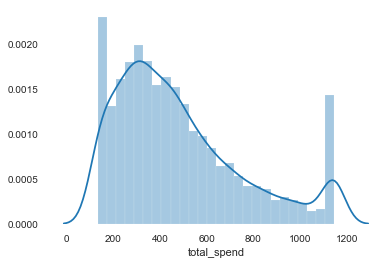

In [53]:
# For Linear regressin y(totalspend) should follow normal istribution
import seaborn as sns
sns.distplot(credit_new.total_spend)

# Now as you can see distribution is right skewed so we need to take log and then plot the graph.

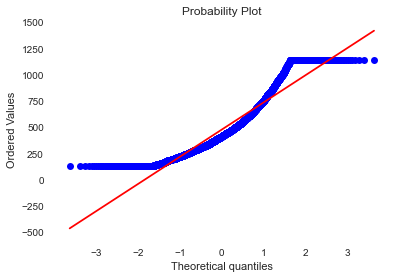

In [54]:
from scipy import stats
import pylab

stats.probplot(credit_new.total_spend, dist="norm", plot=pylab )
pylab.show()

In [55]:
credit_new.total_spend.skew()

0.952415142745768

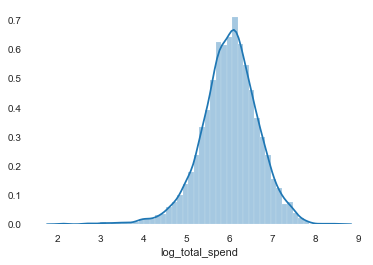

In [56]:
#Visualizing log_total_spend
sb.distplot(credit['log_total_spend'])

In [57]:
credit_new.log_total_spend.skew()

-0.10737592179142055

In [58]:
credit_new

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,20,15,31,11.1,1.200909,2.240091,0,3,14.3,22.0,...,0,0,0,1,1,0,0,0,1,0
1,22,17,15,18.6,1.222020,1.567980,0,2,6.8,29.0,...,1,1,1,1,1,1,1,0,0,0
2,67,14,35,9.9,0.928620,2.536380,13,3,18.8,24.0,...,1,0,0,0,0,0,1,0,0,0
3,23,16,20,5.7,0.101088,1.117200,18,5,8.7,35.0,...,1,0,1,1,1,0,1,1,0,0
4,26,16,23,1.9,0.214659,0.287692,13,4,10.6,32.0,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,68,10,147,8.0,6.373010,7.745920,0,1,64.5,21.0,...,1,0,0,0,0,0,1,0,0,0
4996,51,14,83,15.0,3.336600,9.113400,0,1,40.0,26.0,...,1,0,0,0,0,0,0,0,0,0
4997,75,17,108,10.8,3.557520,8.106480,0,1,53.6,32.0,...,1,1,0,0,0,0,1,0,0,0
4998,47,19,147,10.8,5.021352,11.815981,15,4,72.0,16.0,...,1,0,1,1,1,0,1,0,0,0


#  the correlation of independent variables with target variables


In [59]:
#Columns having corr value with respect to target variable greater then 0.1 or less than -0.075 have been saved, rest were removed.
cor = credit_new.corr()
cor


,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,carvalue,commutetime,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
age,1.000000,-0.095758,0.220088,0.039225,0.144589,0.159429,-0.004041,-0.337739,0.177109,-0.056777,...,0.054874,-0.074777,-0.133616,-0.218427,-0.235697,-0.042543,0.365608,0.015457,0.013055,-0.026311
ed,-0.095758,1.000000,0.196463,0.013256,0.123669,0.141622,0.112108,0.019635,0.157779,-0.008180,...,0.054007,0.300008,0.435953,0.370498,0.377678,0.274151,-0.073941,-0.115442,0.073366,0.107982
income,0.220088,0.196463,1.000000,0.009294,0.608236,0.688107,0.036856,-0.079146,0.851277,-0.022156,...,0.232902,0.145224,0.051770,0.040528,0.043493,0.141746,0.144707,-0.000151,0.067937,0.056742
debtinc,0.039225,0.013256,0.009294,1.000000,0.504013,0.569809,-0.041894,-0.028997,0.013983,-0.000141,...,0.003303,0.000236,0.006512,0.013769,0.000355,0.000830,0.005815,0.010735,0.004858,0.019639
creddebt,0.144589,0.123669,0.608236,0.504013,1.000000,0.639775,0.005297,-0.049714,0.517231,-0.020868,...,0.158249,0.080538,0.030786,0.013818,0.011358,0.071069,0.085778,0.009900,0.022938,0.046707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ownfax_1,-0.042543,0.274151,0.141746,0.000830,0.071069,0.101955,0.033212,0.011256,0.109674,-0.032416,...,0.050193,0.434104,0.243924,0.237789,0.230499,1.000000,-0.024573,-0.014592,0.032549,0.093360
news_1,0.365608,-0.073941,0.144707,0.005815,0.085778,0.097547,0.090134,-0.052414,0.125298,-0.022275,...,0.119674,-0.037949,-0.061753,-0.099716,-0.089811,-0.024573,1.000000,0.020919,0.030136,-0.011148
response_01_1,0.015457,-0.115442,-0.000151,0.010735,0.009900,0.013391,-0.007102,0.004626,0.007862,0.004155,...,-0.002627,-0.023472,-0.107194,-0.069870,-0.096176,-0.014592,0.020919,1.000000,-0.015601,-0.018781
response_02_1,0.013055,0.073366,0.067937,0.004858,0.022938,0.051113,0.032694,0.013232,0.062668,-0.009462,...,0.015718,0.021608,0.039891,0.015485,0.011744,0.032549,0.030136,-0.015601,1.000000,0.028266


In [60]:
#cor.to_csv('corrmf.csv',header = True,index= True)

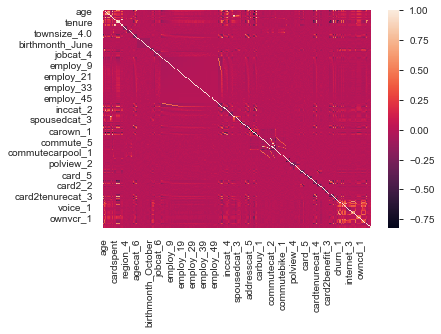

In [61]:
sns.heatmap( cor )

In [62]:
cor = pd.DataFrame(cor['log_total_spend'])
c1 = cor[cor['log_total_spend'] > 0.1]
c2 = cor[cor['log_total_spend'] < -0.075]
c3 = pd.concat([c1,c2],axis=0)
c3.reset_index(inplace=True)
c3.columns = ['col','value']
credit_new = credit_new[c3.col]
credit_new

,income,creddebt,othdebt,carvalue,cardspent,card2spent,total_spend,log_total_spend,agecat_5,inccat_3,...,gender_1,agecat_6,jobcat_2,retire_1,carown_0,carcatvalue_1,card_2,card_3,card2_2,card2_3
0,31,1.200909,2.240091,14.3,91.3045,67.800,149.4600,5.007029,0,0,...,1,0,0,0,0,1,0,1,0,0
1,15,1.222020,1.567980,6.8,91.3045,34.940,133.1060,4.891146,0,0,...,0,0,1,0,0,1,1,0,0,0
2,35,0.928620,2.536380,18.8,184.2200,175.750,359.9700,5.886021,0,0,...,1,1,1,0,0,1,1,0,0,0
3,20,0.101088,1.117200,8.7,340.9900,18.420,359.4100,5.884464,0,0,...,0,0,1,0,0,1,1,0,0,1
4,23,0.214659,0.287692,10.6,255.1000,252.730,507.8300,6.230147,0,0,...,0,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,147,6.373010,7.745920,64.5,782.3155,419.447,1145.1465,7.043288,0,0,...,0,1,0,0,0,0,0,0,0,1
4996,83,3.336600,9.113400,40.0,210.8100,155.540,366.3500,5.903589,1,0,...,0,0,0,0,0,0,0,1,0,0
4997,108,3.557520,8.106480,53.6,782.3155,419.447,1145.1465,7.043288,0,0,...,0,1,0,0,0,0,0,0,1,0
4998,147,5.021352,11.815981,72.0,381.3500,371.600,752.9500,6.623999,0,0,...,0,0,1,0,0,0,0,1,0,0


# feature selection based on importance using F - Regression

In [63]:
# splitting the data: separate out the feature/input/independant columns and dependant variable
feature_columns = credit_new.columns.difference(['log_total_spend', 'total_spend'])

In [64]:
feature_columns

Index(['agecat_5', 'agecat_6', 'carcatvalue_1', 'carcatvalue_3', 'card2_2',
       'card2_3', 'card2spent', 'card_2', 'card_3', 'cardspent', 'carown_0',
       'carown_1', 'carvalue', 'creddebt', 'gender_1', 'inccat_3', 'inccat_4',
       'inccat_5', 'income', 'jobcat_2', 'othdebt', 'owncd_1', 'owndvd_1',
       'ownvcr_1', 'reason_2', 'retire_1'],
      dtype='object')

In [65]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression

In [66]:
# seperate the X and y columns
features = credit_new[feature_columns]
target = credit_new.log_total_spend

# do the f_regression
F_values, p_values  = f_regression( features, target )

# combine the output in dataframe
F_regression_op = pd.DataFrame([feature_columns, F_values.round(2), p_values]).T

# add the column names
F_regression_op.columns = ['Features', 'F_values', 'p_values', ]

In [67]:
F_regression_op

,Features,F_values,p_values
0,agecat_5,62.98,2.56264e-15
1,agecat_6,44.13,3.39334e-11
2,carcatvalue_1,436.56,5.19938e-93
3,carcatvalue_3,364.19,2.00368e-78
4,card2_2,29.83,4.95307e-08
5,card2_3,38.2,6.89659e-10
6,card2spent,8404.3,0
7,card_2,73.87,1.09974e-17
8,card_3,63.47,2.00081e-15
9,cardspent,19549.1,0


In [68]:
feature_columns = list(F_regression_op.loc[ F_regression_op.p_values <= 0.05, 'Features' ])
feature_columns

['agecat_5',
 'agecat_6',
 'carcatvalue_1',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2spent',
 'card_2',
 'card_3',
 'cardspent',
 'carown_0',
 'carown_1',
 'carvalue',
 'creddebt',
 'gender_1',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'income',
 'jobcat_2',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownvcr_1',
 'reason_2',
 'retire_1']

# VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the mode

In [69]:
model_param = 'log_total_spend~ ' + ' + '.join(feature_columns)
model_param

'log_total_spend~ agecat_5 + agecat_6 + carcatvalue_1 + carcatvalue_3 + card2_2 + card2_3 + card2spent + card_2 + card_3 + cardspent + carown_0 + carown_1 + carvalue + creddebt + gender_1 + inccat_3 + inccat_4 + inccat_5 + income + jobcat_2 + othdebt + owncd_1 + owndvd_1 + ownvcr_1 + reason_2 + retire_1'

In [70]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices( model_param,credit_new, return_type = 'dataframe' )

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF Factor'] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,54.7
1,agecat_5,1.3
2,agecat_6,2.1
3,carcatvalue_1,4.5
4,carcatvalue_3,5.4
5,card2_2,1.3
6,card2_3,1.3
7,card2spent,1.6
8,card_2,1.3
9,card_3,1.3


In [71]:
feature_columns=['agecat_5',
 'agecat_6',
 'carcatvalue_1',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2spent',
 'card_2',
 'card_3',
 'cardspent',
 'carown_0',
 'carown_1',
 'carvalue',
 'creddebt',
 'gender_1',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'income',
 'jobcat_2',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownvcr_1',
 'reason_2',
 'retire_1']

In [72]:
feature_columns.remove('income')
feature_columns.remove('carvalue')
feature_columns.remove('inccat_5')

In [73]:
feature_columns

['agecat_5',
 'agecat_6',
 'carcatvalue_1',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2spent',
 'card_2',
 'card_3',
 'cardspent',
 'carown_0',
 'carown_1',
 'creddebt',
 'gender_1',
 'inccat_3',
 'inccat_4',
 'jobcat_2',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownvcr_1',
 'reason_2',
 'retire_1']

In [74]:
credit_new = pd.concat([credit_new["log_total_spend"],credit_new[feature_columns]], axis=1)

In [75]:
credit_new

,log_total_spend,agecat_5,agecat_6,carcatvalue_1,carcatvalue_3,card2_2,card2_3,card2spent,card_2,card_3,...,gender_1,inccat_3,inccat_4,jobcat_2,othdebt,owncd_1,owndvd_1,ownvcr_1,reason_2,retire_1
0,5.007029,0,0,1,0,0,0,67.800,0,1,...,1,0,0,0,2.240091,0,1,1,0,0
1,4.891146,0,0,1,0,0,0,34.940,1,0,...,0,0,0,1,1.567980,1,1,1,0,0
2,5.886021,0,1,1,0,0,0,175.750,1,0,...,1,0,0,1,2.536380,1,1,1,1,0
3,5.884464,0,0,1,0,0,1,18.420,1,0,...,0,0,0,1,1.117200,1,1,1,0,0
4,6.230147,0,0,1,0,0,0,252.730,0,0,...,0,0,0,1,0.287692,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.043288,0,1,0,1,0,1,419.447,0,0,...,0,0,0,0,7.745920,1,1,1,0,0
4996,5.903589,1,0,0,1,0,0,155.540,0,1,...,0,0,1,0,9.113400,1,1,1,0,0
4997,7.043288,0,1,0,1,1,0,419.447,0,0,...,0,0,1,0,8.106480,1,1,1,0,0
4998,6.623999,0,0,0,1,0,0,371.600,0,1,...,0,0,0,1,11.815981,1,1,1,0,0


# Splitting data into dependent and independent categories

In [76]:
def split(data):
    features_log = data.columns.difference(['log_total_spend'])
    feat_log = data[features_log]
    pre_log = data["log_total_spend"].copy()
    return feat_log, pre_log

In [77]:
feat,pre = split(credit_new)

In [78]:
feat

,agecat_5,agecat_6,carcatvalue_1,carcatvalue_3,card2_2,card2_3,card2spent,card_2,card_3,cardspent,...,gender_1,inccat_3,inccat_4,jobcat_2,othdebt,owncd_1,owndvd_1,ownvcr_1,reason_2,retire_1
0,0,0,1,0,0,0,67.800,0,1,91.3045,...,1,0,0,0,2.240091,0,1,1,0,0
1,0,0,1,0,0,0,34.940,1,0,91.3045,...,0,0,0,1,1.567980,1,1,1,0,0
2,0,1,1,0,0,0,175.750,1,0,184.2200,...,1,0,0,1,2.536380,1,1,1,1,0
3,0,0,1,0,0,1,18.420,1,0,340.9900,...,0,0,0,1,1.117200,1,1,1,0,0
4,0,0,1,0,0,0,252.730,0,0,255.1000,...,0,0,0,1,0.287692,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,1,0,1,0,1,419.447,0,0,782.3155,...,0,0,0,0,7.745920,1,1,1,0,0
4996,1,0,0,1,0,0,155.540,0,1,210.8100,...,0,0,1,0,9.113400,1,1,1,0,0
4997,0,1,0,1,1,0,419.447,0,0,782.3155,...,0,0,1,0,8.106480,1,1,1,0,0
4998,0,0,0,1,0,0,371.600,0,1,381.3500,...,0,0,0,1,11.815981,1,1,1,0,0


In [79]:
pre

0       5.007029
1       4.891146
2       5.886021
3       5.884464
4       6.230147
          ...   
4995    7.043288
4996    5.903589
4997    7.043288
4998    6.623999
4999    6.010924
Name: log_total_spend, Length: 5000, dtype: float64

# Variance Inflation Factor analysis on cleaned data

In [80]:
vif_data = feat
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
vif["features"] = vif_data.columns
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
18,19.677825,owncd_1
20,17.229909,ownvcr_1
19,15.940029,owndvd_1
11,10.336780,carown_1
9,6.416315,cardspent
2,4.948331,carcatvalue_1
6,4.506202,card2spent
17,4.306675,othdebt
12,3.359184,creddebt
10,3.217514,carown_0


In [81]:
feature_columns

['agecat_5',
 'agecat_6',
 'carcatvalue_1',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2spent',
 'card_2',
 'card_3',
 'cardspent',
 'carown_0',
 'carown_1',
 'creddebt',
 'gender_1',
 'inccat_3',
 'inccat_4',
 'jobcat_2',
 'othdebt',
 'owncd_1',
 'owndvd_1',
 'ownvcr_1',
 'reason_2',
 'retire_1']

In [82]:
feature_columns.remove('owncd_1')
feature_columns.remove('ownvcr_1')
feature_columns.remove('owndvd_1')
feature_columns.remove('carown_1')
feature_columns

['agecat_5',
 'agecat_6',
 'carcatvalue_1',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2spent',
 'card_2',
 'card_3',
 'cardspent',
 'carown_0',
 'creddebt',
 'gender_1',
 'inccat_3',
 'inccat_4',
 'jobcat_2',
 'othdebt',
 'reason_2',
 'retire_1']

In [83]:
credit_new = pd.concat([credit_new["log_total_spend"],credit_new[feature_columns]], axis=1)

In [84]:
credit_new

,log_total_spend,agecat_5,agecat_6,carcatvalue_1,carcatvalue_3,card2_2,card2_3,card2spent,card_2,card_3,cardspent,carown_0,creddebt,gender_1,inccat_3,inccat_4,jobcat_2,othdebt,reason_2,retire_1
0,5.007029,0,0,1,0,0,0,67.800,0,1,91.3045,0,1.200909,1,0,0,0,2.240091,0,0
1,4.891146,0,0,1,0,0,0,34.940,1,0,91.3045,0,1.222020,0,0,0,1,1.567980,0,0
2,5.886021,0,1,1,0,0,0,175.750,1,0,184.2200,0,0.928620,1,0,0,1,2.536380,1,0
3,5.884464,0,0,1,0,0,1,18.420,1,0,340.9900,0,0.101088,0,0,0,1,1.117200,0,0
4,6.230147,0,0,1,0,0,0,252.730,0,0,255.1000,1,0.214659,0,0,0,1,0.287692,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.043288,0,1,0,1,0,1,419.447,0,0,782.3155,0,6.373010,0,0,0,0,7.745920,0,0
4996,5.903589,1,0,0,1,0,0,155.540,0,1,210.8100,0,3.336600,0,0,1,0,9.113400,0,0
4997,7.043288,0,1,0,1,1,0,419.447,0,0,782.3155,0,3.557520,0,0,1,0,8.106480,0,0
4998,6.623999,0,0,0,1,0,0,371.600,0,1,381.3500,0,5.021352,0,0,0,1,11.815981,0,0


In [85]:
drop=['owncd_1','ownvcr_1','owndvd_1','carown_1'] #Attributes with vif greater then 10 dropped one at a time
vif_data = feat.drop(drop,axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
vif["features"] = vif_data.columns
vif.sort_values(by='VIF Factor', ascending=False) 

,VIF Factor,features
9,5.791213,cardspent
6,4.415110,card2spent
16,4.181651,othdebt
11,3.310815,creddebt
2,2.834095,carcatvalue_1
1,2.591907,agecat_6
18,2.444908,retire_1
3,2.193958,carcatvalue_3
12,1.923350,gender_1
0,1.667527,agecat_5


In [86]:
vif_feat = vif_data[vif.features] #Final data set after VIF 
vif_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   agecat_5       5000 non-null   uint8  
 1   agecat_6       5000 non-null   uint8  
 2   carcatvalue_1  5000 non-null   uint8  
 3   carcatvalue_3  5000 non-null   uint8  
 4   card2_2        5000 non-null   uint8  
 5   card2_3        5000 non-null   uint8  
 6   card2spent     5000 non-null   float64
 7   card_2         5000 non-null   uint8  
 8   card_3         5000 non-null   uint8  
 9   cardspent      5000 non-null   float64
 10  carown_0       5000 non-null   uint8  
 11  creddebt       5000 non-null   float64
 12  gender_1       5000 non-null   uint8  
 13  inccat_3       5000 non-null   uint8  
 14  inccat_4       5000 non-null   uint8  
 15  jobcat_2       5000 non-null   uint8  
 16  othdebt        5000 non-null   float64
 17  reason_2       5000 non-null   uint8  
 18  retire_1

# Select K Best

In [87]:
#Using Kbest to select 19 variables
def kbest(x,y):
    k = SelectKBest(f_regression, k=19).fit_transform(x, y)
    return k

In [88]:
kbest_feat=kbest(feat,pre)
kbest_feat

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

# PCA

In [89]:
#pca done on independent variables to select 23 variables
def pca(x):
    scaler = StandardScaler()
    scaler.fit(x)
    train_img = scaler.transform(x)
    
    pca = PCA( n_components=19, random_state=123)    
    pca.fit(x)
    pca_feat = pca.transform(x) #We'll use pca_feat as set of independent variable 
    pca.explained_variance_ratio_.round(3)
    
    return pca_feat

In [90]:
pca_feat=pca(feat)
pca_feat

array([[-2.46851385e+02,  1.60373234e+01,  1.18581586e-01, ...,
        -4.95911931e-02, -2.28605609e-02, -1.09926704e-02],
       [-2.60025799e+02, -1.40681078e+01, -3.88192222e-01, ...,
         2.18140180e-02, -9.72913957e-04, -8.92911506e-03],
       [-1.18456843e+02,  7.76889874e+01, -4.82542455e-01, ...,
        -2.35061327e-02,  9.40988452e-01, -1.17364275e-01],
       ...,
       [ 5.27194331e+02,  6.12119895e+01,  2.62290070e+00, ...,
         2.11438436e-01, -1.19942125e-01,  2.73138220e-01],
       [ 1.40696457e+02,  1.78113509e+02,  8.24589832e+00, ...,
         1.59729748e-01, -1.19250316e-01, -4.39726007e-01],
       [-5.51986199e+01,  8.96157688e+00, -1.32176493e-02, ...,
         3.37074799e-01, -1.39546708e-02,  1.83523131e-01]])

# Model Building

In [91]:

# Function to build OLS, check summary and visualize any residual outliers using Cooks's distance
def model_ols(model,x,y):
    #splitting data in to train and test
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 123)
    #adding constant to independent train and test sets
    train_x=sm.add_constant(train_x)
    test_x=sm.add_constant(test_x)
    #Fitting model
    mod = ols(train_y,train_x).fit()
    print(mod.summary())
    #Storing summary frame
    o = (mod.get_influence()).summary_frame()
    #Plotting a scatter plot for standardized residuals and Cooks distance
    plt.figure(figsize=(8,5))
    plt.scatter(o.standard_resid,o.cooks_d)
    print(plt.show())
    return o

# Function to build and evaluate other models
def model_build_cum_evaluation(model,x,y):
    #Splitting data in to train and test
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 123)
    #Fitting model
    model.fit(train_x,train_y)
    #Predicting values for train_x and test_x
    model_check = model.predict(train_x)
    model_pred = model.predict(test_x)
    
    #Printing error metrices, r2 score and also cross validating the model.
    print ('MAE:', metrics.mean_absolute_error(test_y, model_pred))
    print ('MSE train:', metrics.mean_squared_error(train_y, model_check))
    print ('MSE test:', metrics.mean_squared_error(test_y, model_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, model_pred)))
    print ('R2: ', metrics.r2_score(test_y, model_pred))
    print ('Cross_val:',cross_val_score(model, x, y,n_jobs=-1,cv=50,scoring='r2').mean()*100)

In [92]:
kbest_feat

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

OLS for final dataset
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1836.
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:53:01   Log-Likelihood:                 1112.5
No. Observations:                3500   AIC:                            -2185.
Df Residuals:                    3480   BIC:                            -2062.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0481

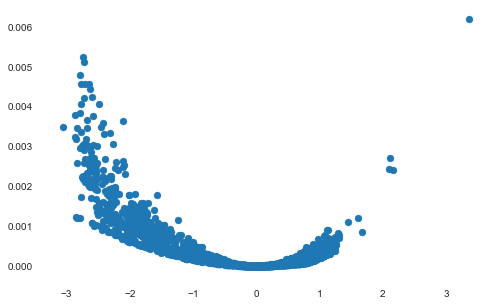

None

OLS for final dataset after pca
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1844.
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:53:31   Log-Likelihood:                 1118.6
No. Observations:                3500   AIC:                            -2197.
Df Residuals:                    3480   BIC:                            -2074.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

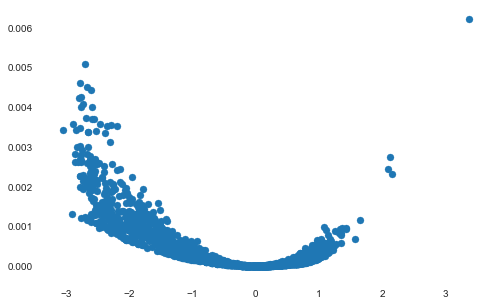

None

OLS for final dataset after selectkbest
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1841.
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:54:00   Log-Likelihood:                 1116.8
No. Observations:                3500   AIC:                            -2194.
Df Residuals:                    3480   BIC:                            -2070.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

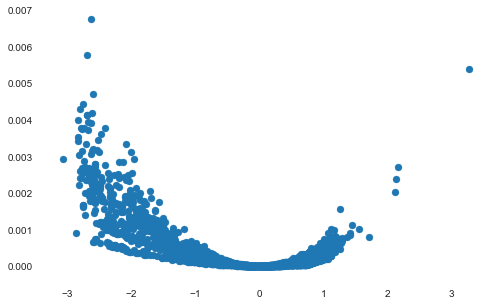

None


In [93]:

#OLS on original data set
ols=sm.OLS
print('OLS for final dataset')
a=model_ols(ols,vif_feat,pre)
print()
print('OLS for final dataset after pca')
b=model_ols(ols,pca_feat,pre)
print()
print('OLS for final dataset after selectkbest')
c=model_ols(ols,kbest_feat,pre)

# linear Regression

In [94]:
lr = LinearRegression(n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(lr,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(lr,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(lr,kbest_feat,pre)



Orginal data set:-
Score for original data set :
MAE: 0.13973413553528458
MSE train: 0.031005843661613346
MSE test: 0.03025877777278925
RMSE: 0.17395050380148155
R2:  0.9024676907649405
Cross_val: 90.55479399559664

Score of orginal data set after PCA
MAE: 0.13941803605540318
MSE train: 0.030897107019722723
MSE test: 0.03013450243090685
RMSE: 0.17359292160369572
R2:  0.9028682641511421
Cross_val: 90.5922356926731

Sore of original data set after SelectKBest
MAE: 0.1397400323947275
MSE train: 0.030929448529927694
MSE test: 0.03027357668717831
RMSE: 0.17399303631806162
R2:  0.9024199898199329
Cross_val: 90.57194359402446


# Random Forest Regressor

In [95]:
#Random Forest
random_forest = RandomForestRegressor(n_estimators=100,n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(random_forest,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(random_forest,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(random_forest,kbest_feat,pre)

Orginal data set:-
Score for original data set :
MAE: 0.01136951955264238
MSE train: 9.13795316284834e-05
MSE test: 0.0008557534119834534
RMSE: 0.029253263270675522
R2:  0.9972416729111384
Cross_val: 99.7961288876166

Score of orginal data set after PCA
MAE: 0.01343920441864906
MSE train: 0.0001183935214379307
MSE test: 0.000973008484811662
RMSE: 0.031193083925954837
R2:  0.9968637277704478
Cross_val: 99.76289558500716

Sore of original data set after SelectKBest
MAE: 0.011191578027010955
MSE train: 9.681364350989455e-05
MSE test: 0.0008656187115290355
RMSE: 0.02942139887104343
R2:  0.9972098743549244
Cross_val: 99.79473467318637


# Support Vector Regressor

In [96]:
# Support Vector Machine
svm = SVR()

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(svm,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(svm,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(svm,kbest_feat,pre)

Orginal data set:-
Score for original data set :
MAE: 0.05237379577807557
MSE train: 0.0038297676148215647
MSE test: 0.0038178420618972505
RMSE: 0.06178868878603308
R2:  0.9876940517760624
Cross_val: 98.93290613667608

Score of orginal data set after PCA
MAE: 0.05248931960132296
MSE train: 0.0037291086017324023
MSE test: 0.0038490894652509437
RMSE: 0.062041030497977254
R2:  0.9875933328564295
Cross_val: 98.8699003546484

Sore of original data set after SelectKBest
MAE: 0.05232446323800883
MSE train: 0.003822180700767085
MSE test: 0.0038104845126838735
RMSE: 0.06172912207932228
R2:  0.9877177671676912
Cross_val: 98.93214281932808


# Gradient Boosting Regressor

In [97]:
gradient_boosted = GradientBoostingRegressor()

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(gradient_boosted,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(gradient_boosted,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(gradient_boosted,kbest_feat,pre)

Orginal data set:-
Score for original data set :
MAE: 0.021612057875555042
MSE train: 0.0005983545843242984
MSE test: 0.0012762172392203738
RMSE: 0.035724182834886146
R2:  0.9958864031005678
Cross_val: 99.709365202814

Score of orginal data set after PCA
MAE: 0.018451861149093526
MSE train: 0.0005649093289627884
MSE test: 0.0011430002841600533
RMSE: 0.03380828721127489
R2:  0.996315797749415
Cross_val: 99.68523556165748

Sore of original data set after SelectKBest
MAE: 0.02144581783370962
MSE train: 0.0006114176618711092
MSE test: 0.0012483137319699849
RMSE: 0.03533148358008739
R2:  0.995976343729311
Cross_val: 99.70834075332817


# Lasso

In [98]:
#Lasso
ls = Lasso(alpha=0.001)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(ls,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(ls,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(ls,kbest_feat,pre)

Orginal data set:-
Score for original data set :
MAE: 0.14014642708059852
MSE train: 0.03111329034040026
MSE test: 0.030324528658559727
RMSE: 0.1741393943327004
R2:  0.9022557576931026
Cross_val: 90.54740506923736

Score of orginal data set after PCA
MAE: 0.1399279153397951
MSE train: 0.031000627977873965
MSE test: 0.030207613297496147
RMSE: 0.17380337539155027
R2:  0.9026326078499466
Cross_val: 90.57550922345548

Sore of original data set after SelectKBest
MAE: 0.13993414173308855
MSE train: 0.031038973906450298
MSE test: 0.03025426479458621
RMSE: 0.17393753129956227
R2:  0.9024822373268993
Cross_val: 90.56217592632308


# K Neighbors Regressor

In [99]:
#knn
knn = KNeighborsRegressor(n_neighbors=50,n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(knn,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(knn,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(knn,kbest_feat,pre)

Orginal data set:-
Score for original data set :
MAE: 0.015156577405903081
MSE train: 0.0009495075341525173
MSE test: 0.001242650381059227
RMSE: 0.03525124651780738
R2:  0.9959945982568561
Cross_val: 99.7157256722995

Score of orginal data set after PCA
MAE: 0.015155646208167095
MSE train: 0.0009496630912869244
MSE test: 0.0012439515817782572
RMSE: 0.03526969778405051
R2:  0.9959904041313743
Cross_val: 99.71582865838859

Sore of original data set after SelectKBest
MAE: 0.015160840216706736
MSE train: 0.0009493154913940875
MSE test: 0.001244220479151998
RMSE: 0.035273509595048776
R2:  0.9959895374016602
Cross_val: 99.71580226002307


# XGB Regressor

In [100]:
#xgboost
xg = XGBRegressor(n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(xg,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(xg,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(xg,kbest_feat,pre)

Orginal data set:-
Score for original data set :
MAE: 0.01636965379301595
MSE train: 3.445697752578866e-05
MSE test: 0.0009740177246208224
RMSE: 0.03120925703410484
R2:  0.9968604747147595
Cross_val: 99.7350843554476

Score of orginal data set after PCA
MAE: 0.018912549511656232
MSE train: 4.904302080216137e-05
MSE test: 0.0011412446258848626
RMSE: 0.033782312322942945
R2:  0.9963214567157849
Cross_val: 99.69206962752739

Sore of original data set after SelectKBest
MAE: 0.01648913723106376
MSE train: 3.586985159977664e-05
MSE test: 0.0010079524008938117
RMSE: 0.03174826610846349
R2:  0.9967510939801871
Cross_val: 99.73675669536588


# model check

In [101]:
# method : divide the data into training and testing
train, test = train_test_split(credit_new, test_size = 0.3, random_state = 123)

In [102]:
import statsmodels.formula.api as smf

In [103]:
m_equation = 'log_total_spend ~ ' + ' + '.join(feature_columns)
lm = smf.ols( m_equation, train).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1836.
Date:                Thu, 20 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:01:39   Log-Likelihood:                 1112.5
No. Observations:                3500   AIC:                            -2185.
Df Residuals:                    3480   BIC:                            -2062.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0481      0.012    404.868

In [104]:
lm.rsquared

0.9093107442370897

In [105]:
lm.rsquared_adj

0.908815601748729

In [106]:
# Step predict  training data
train['pred_spend'] = np.exp(lm.predict(train))

c:\python3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
# Step  testing/validation data
test['pred_spend'] = np.exp(lm.predict(test))

c:\python3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
train["total_spend"]=np.exp(train.log_total_spend)
test["total_spend"]=np.exp(test.log_total_spend)

c:\python3.7\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
train[['total_spend','pred_spend']]

,total_spend,pred_spend
4036,668.140000,572.264884
2883,181.830000,229.458900
4162,219.540000,236.817036
4640,500.010000,426.547641
2430,1145.146489,1861.010003
...,...,...
1593,207.190000,232.470234
4060,177.010000,217.685571
1346,567.870000,490.271359
3454,302.950000,281.964493


In [110]:
test[['total_spend','pred_spend']]

,total_spend,pred_spend
2648,325.490000,309.422493
2456,515.020000,438.665538
4557,561.520000,468.056746
4884,483.450000,420.911262
92,490.750000,434.317943
...,...,...
3014,403.050000,359.625257
734,133.105999,209.249946
452,216.280000,237.726024
2558,354.140000,325.764462


# Correlation

## Here we are seeing that errors are high for the majority of data

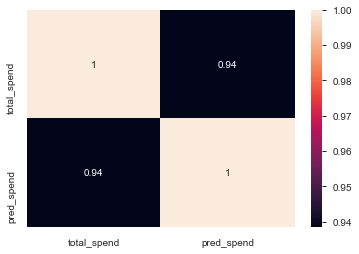

In [111]:
sns.heatmap(train[['total_spend','pred_spend']].corr(),annot = True)

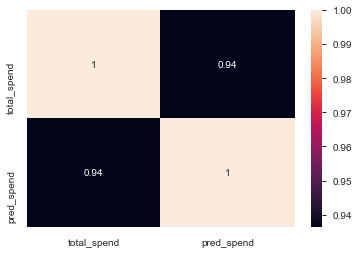

In [112]:
sns.heatmap(test[['total_spend','pred_spend']].corr(),annot = True)

# Scatter plots

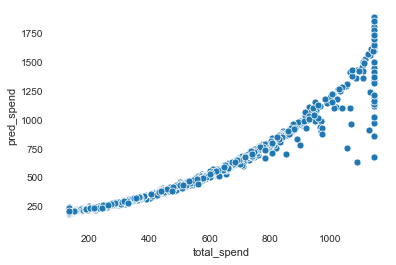

In [113]:
sns.scatterplot(test.total_spend,test.pred_spend) ## Straight line is tilting downwards due to high number of errors

# Lets check that our errors are normally distributed or not

In [114]:
test['errors']=test.total_spend - test.pred_spend

c:\python3.7\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


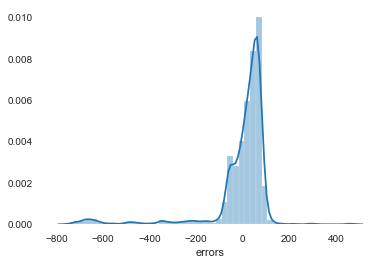

In [115]:
sns.distplot(test.errors)

# Assumption 4 - Errors should be homoscedastic accross different values of Y

### Here we can see that errors are homoscedastic across the Y there is no heteroscedasticity present in errors

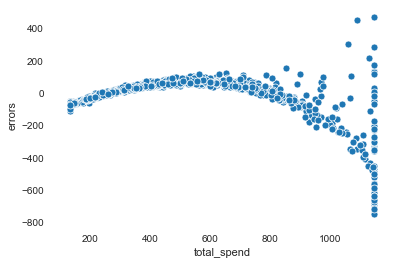

In [116]:
sns.scatterplot(test.total_spend,test.errors)

In [117]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['total_spend'] - train['pred_spend'])/train['total_spend'])
MAPE_test = np.mean(np.abs(test['total_spend'] - test['pred_spend'])/test['total_spend'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.14852372403266242  |  MAPE of testing data:  0.14594872103698436


In [118]:
train

,log_total_spend,agecat_5,agecat_6,carcatvalue_1,carcatvalue_3,card2_2,card2_3,card2spent,card_2,card_3,...,creddebt,gender_1,inccat_3,inccat_4,jobcat_2,othdebt,reason_2,retire_1,pred_spend,total_spend
4036,6.504498,0,1,0,0,1,0,210.0400,0,0,...,2.191000,1,0,0,0,4.809000,0,1,572.264884,668.140000
2883,5.203072,0,1,0,0,0,0,14.8195,1,0,...,2.029536,1,0,0,0,2.146464,0,0,229.458900,181.830000
4162,5.391534,0,0,0,0,1,0,19.0400,0,0,...,0.238196,0,0,0,1,1.077804,0,0,236.817036,219.540000
4640,6.214628,0,0,0,0,0,0,85.9800,1,0,...,1.059345,0,0,0,0,6.905655,0,0,426.547641,500.010000
2430,7.043288,0,0,1,0,0,0,416.8400,0,0,...,3.644352,0,0,0,0,1.683648,0,0,1861.010003,1145.146489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,5.333636,1,0,1,0,0,0,27.5500,0,1,...,0.358668,1,0,0,1,4.015332,0,0,232.470234,207.190000
4060,5.176206,0,0,0,0,0,1,18.7200,1,0,...,0.521136,0,0,0,1,1.734864,0,0,217.685571,177.010000
1346,6.341893,1,0,1,0,0,0,162.8300,1,0,...,3.041280,0,0,0,0,6.462720,0,0,490.271359,567.870000
3454,5.713568,0,0,0,0,1,0,94.2400,0,0,...,6.371568,0,0,0,0,6.270432,0,0,281.964493,302.950000


In [119]:
# Step 6: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_spend'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_spend'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = train[['Deciles', 'total_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['total_spend']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = test[['Deciles', 'total_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['total_spend']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

c:\python3.7\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\python3.7\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [120]:
Decile_analysis_train

,Deciles,pred_spend,total_spend
0,9,1366.942996,1070.053760
1,8,769.731461,793.537064
2,7,546.358108,616.988629
3,6,443.930140,515.235543
4,5,381.001670,442.176514
5,4,335.174400,380.251057
6,3,296.019952,321.169086
7,2,265.591366,268.821857
8,1,235.109312,210.999846
9,0,200.793890,145.068879


In [121]:
Decile_analysis_test

,Deciles,pred_spend,total_spend
0,9,1373.533492,1063.479871
1,8,746.400115,780.510953
2,7,556.313734,624.116400
3,6,452.474262,524.759333
4,5,390.838191,454.956200
5,4,344.897040,395.385533
6,3,307.156629,340.142267
7,2,276.686071,290.768800
8,1,245.341482,229.976080
9,0,206.810310,154.161426


## Decision Tree

## CART MSE - CLASSIFICATION AND REGRESSION TREES FOR MEAN SQUARED ERRORS

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [123]:
dtr = DecisionTreeRegressor()

In [124]:
param_grid={'max_depth':np.arange(1,4),
'max_features':np.arange(1,19),
'criterion':['mse']}

In [125]:
 tree_reg = GridSearchCV(dtr,param_grid,cv=10)

In [126]:
tree_reg.fit(train[feature_columns],train.log_total_spend)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': array([1, 2, 3]),
                         'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])})

In [127]:
tree_reg.best_params_

{'criterion': 'mse', 'max_depth': 3, 'max_features': 18}

In [128]:
tree_hyped = DecisionTreeRegressor(criterion='mse',max_depth=3,max_features=17)

In [129]:
tree_hyped.fit(train[feature_columns],train.log_total_spend)

DecisionTreeRegressor(max_depth=3, max_features=17)

In [130]:
# Step 4: predict the sales on the training data
train_decision = pd.DataFrame({'Actual':train.total_spend,'predicted':np.exp(tree_hyped.predict(train[feature_columns]))})

In [131]:
test_decision = pd.DataFrame({'Actual':test.total_spend,'predicted':np.exp(tree_hyped.predict(test[feature_columns]))})

In [132]:
test_decision.head(5)

,Actual,predicted
2648,325.49,278.989373
2456,515.02,453.120505
4557,561.52,638.711243
4884,483.45,453.120505
92,490.75,453.120505


In [133]:
train_decision.head(5)

,Actual,predicted
4036,668.140000,638.711243
2883,181.830000,273.320453
4162,219.540000,273.320453
4640,500.010000,453.120505
2430,1145.146489,1078.681238


## Decision tree model evaluation

## Mean errors

In [134]:
train_decision.mean()

Actual       476.430224
predicted    470.012854
dtype: float64

In [135]:
test_decision.mean()

Actual       485.825686
predicted    478.208889
dtype: float64

## MSE and RMSE

In [136]:
mse_train = metrics.mean_squared_error(train_decision.Actual,train_decision.predicted)
mse_test=metrics.mean_squared_error(test_decision.Actual,test_decision.predicted)
#------------------------------------------------------------
RMSE_train=np.sqrt(mse_train)
RMSE_test=np.sqrt(mse_test)

print('MSE',mse_train,'|','RMSE',RMSE_train)
print('MSE',mse_test,'|','RMSE',RMSE_test)

MSE 7300.468605277347 | RMSE 85.44277971413001
MSE 8235.646096582404 | RMSE 90.75046058606206


## MAE AND MAPE - Mean absolute error and Mean absolute percentage Error

In [137]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAE_TRAIN_dec = metrics.mean_absolute_error(train_decision.Actual,train_decision.predicted)
MAE_TEST_dec = metrics.mean_absolute_error(test_decision.Actual,test_decision.predicted)

MAPE_train = '%.3f' % np.mean(np.abs(train_decision['Actual'] - train_decision['predicted'])/train_decision['Actual'])
MAPE_test = '%.3f' % np.mean(np.abs(test_decision['Actual'] - test_decision['predicted'])/test_decision['Actual'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)
print('MAE_TRAIN',MAE_TRAIN_dec,'|','MAE_TEST',MAE_TEST_dec)

MAPE of training data:  0.139  |  MAPE of testing data:  0.142
MAE_TRAIN 60.978499216524185 | MAE_TEST 64.82028090295177


# Scatter plot
Model has less errors as compared to linear regression

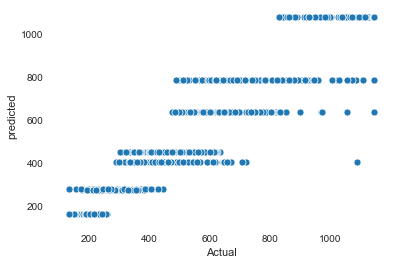

In [138]:
sns.scatterplot(test_decision.Actual,test_decision.predicted)

## Correlation matrix

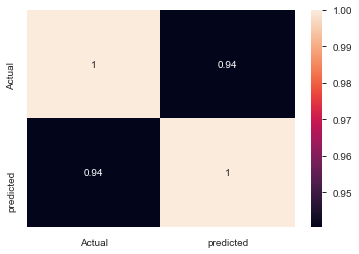

In [139]:
sns.heatmap(test_decision[['Actual','predicted']].corr(),annot = True)

# Decile analysis for testing data

In [140]:
test_decision['deciles'] = pd.qcut(test_decision.predicted,10,labels = False,duplicates='drop')

In [141]:
test_decision.head()

,Actual,predicted,deciles
2648,325.49,278.989373,1
2456,515.02,453.120505,3
4557,561.52,638.711243,4
4884,483.45,453.120505,3
92,490.75,453.120505,3


## Here we can see that output is still directionally unstable for last 5 deciles

In [142]:
test_decision.groupby('deciles')[['Actual','predicted']].mean().sort_index(ascending = False).reset_index()

,deciles,Actual,predicted
0,6,1087.533072,1078.681238
1,5,783.822384,787.334896
2,4,654.399520,638.711243
3,3,459.475354,453.120505
4,2,423.005433,403.068972
5,1,277.879814,278.989373
6,0,232.494722,226.190178


# Bagging

In [143]:
from sklearn.ensemble import BaggingRegressor

In [144]:
param_grid={'n_estimators':[100,200,300,400],
'max_samples':[0.9,0.8,0.7,0.6],}

# Running BaggingRegressor for regression, keeping warm_start = True so that our model will retain last iteration and will do incremental 100 in every next iteration

In [145]:
bagg_reg = GridSearchCV(BaggingRegressor(warm_start=True),param_grid,cv = 10)

In [146]:
bagg_reg.fit(train[feature_columns],train.log_total_spend)

GridSearchCV(cv=10, estimator=BaggingRegressor(warm_start=True),
             param_grid={'max_samples': [0.9, 0.8, 0.7, 0.6],
                         'n_estimators': [100, 200, 300, 400]})

In [147]:
bagg_reg.best_params_ ## These are the best parameters for our bagging model:

{'max_samples': 0.9, 'n_estimators': 200}

In [148]:
bag_reg = BaggingRegressor(max_samples = 0.8,n_estimators=200)

In [149]:
bag_reg.fit(train[feature_columns],train.log_total_spend)

BaggingRegressor(max_samples=0.8, n_estimators=200)

#### Predictions

In [150]:
train_bagging = pd.DataFrame({'Actual':train.total_spend,'predicted':np.exp(bag_reg.predict(train[feature_columns]))})
test_bagging = pd.DataFrame({'Actual':test.total_spend,'predicted':np.exp(bag_reg.predict(test[feature_columns]))})

In [151]:
test_bagging.head(10)

,Actual,predicted
2648,325.490000,324.945547
2456,515.020000,515.362190
4557,561.520000,559.525028
4884,483.450000,486.611082
92,490.750000,488.471792
4038,133.105999,133.166643
30,465.430000,466.837792
1746,167.740000,166.285811
1692,358.580000,358.593819
2277,360.970000,360.737368


In [152]:
train_bagging.head(10)

,Actual,predicted
4036,668.140000,668.719972
2883,181.830000,187.129829
4162,219.540000,218.922693
4640,500.010000,500.901403
2430,1145.146489,1145.146489
449,1145.146489,1082.264528
4179,245.860000,245.854299
4763,416.020000,415.012555
749,357.520000,357.789601
2525,299.490000,301.010202


# Bagging model evaluation

In [153]:
train_bagging.mean() ## Not much difference among the mean values hence errors are stable 

Actual       476.430224
predicted    476.234636
dtype: float64

In [154]:
test_bagging.mean()

Actual       485.825686
predicted    485.217287
dtype: float64

# MSE AND RMSE - Mean Squared Errors and Root Mean Squared Errors

In [155]:
mse_train = metrics.mean_squared_error(train_bagging.Actual,train_bagging.predicted)
mse_test=metrics.mean_squared_error(test_bagging.Actual,test_bagging.predicted)
#------------------------------------------------------------
RMSE_train=np.sqrt(mse_train)
RMSE_test=np.sqrt(mse_test)

print('MSE',mse_train,'|','RMSE',RMSE_train)
print('MSE',mse_test,'|','RMSE',RMSE_test)

MSE 86.65842678533674 | RMSE 9.309050799374592
MSE 498.97295463784815 | RMSE 22.337702537142178


## Mae and Mape - Mean absolute error and Mean absolute percentage error
We can see that MAPE value for training and testing are very low hence we can say that our model is explaining(reducing) high number of errors

In [156]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAE_TRAIN_bag = metrics.mean_absolute_error(train_bagging.Actual,train_bagging.predicted)
MAE_TEST_bag = metrics.mean_absolute_error(test_bagging.Actual,test_bagging.predicted)

MAPE_train = '%.3f' % np.mean(np.abs(train_bagging['Actual'] - train_bagging['predicted'])/train_bagging['Actual'])
MAPE_test = '%.3f' % np.mean(np.abs(test_bagging['Actual'] - test_bagging['predicted'])/test_bagging['Actual'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)
print('MAE_TRAIN',MAE_TRAIN_bag,'|','MAE_TEST',MAE_TEST_bag)

MAPE of training data:  0.005  |  MAPE of testing data:  0.011
MAE_TRAIN 2.840303997276595 | MAE_TEST 6.206048123881071


## Correlation

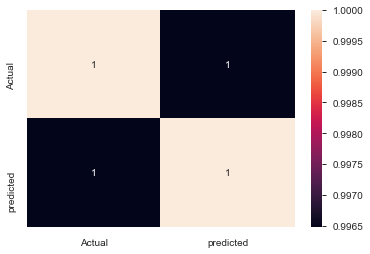

In [157]:
sns.heatmap(test_bagging[['Actual','predicted']].corr(),annot = True)

# Scatter plot
Model is showing high accuracy as we are getting straight line with our actual and predicted values

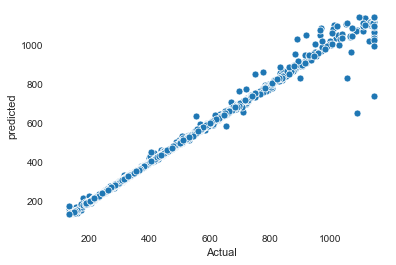

In [158]:
sns.scatterplot(test_bagging.Actual,test_bagging.predicted)

## Decile analysis
We can see that outputs are good for almost every observation

In [159]:
test_bagging['Deciles'] = pd.qcut(test_bagging.predicted,10,labels = False)

In [160]:
test_bagging.groupby('Deciles')[['Actual','predicted']].mean().sort_index(ascending = False).reset_index()

,Deciles,Actual,predicted
0,9,1068.495115,1067.257110
1,8,773.215777,768.973750
2,7,626.800600,623.163840
3,6,524.982200,525.553547
4,5,455.042133,456.187320
5,4,396.564333,396.855001
6,3,339.462333,339.553993
7,2,290.614200,290.670481
8,1,230.831267,231.420999
9,0,152.248906,152.536826


# Random Forest

In [161]:
from sklearn.ensemble import RandomForestRegressor

In [162]:
param_grid1={'n_estimators':[100,200,300,400],
'max_depth':np.arange(1,15),}

In [163]:
rndm_frst_reg = GridSearchCV(RandomForestRegressor(warm_start = True),param_grid1 , cv = 10)

In [164]:
rndm_frst_reg.fit(train[feature_columns],train.log_total_spend)

GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': [100, 200, 300, 400]})

In [165]:
rndm_frst_reg.cv_results_

{'mean_fit_time': array([0.52135313, 0.74105482, 1.1610008 , 1.15173972, 0.45774188,
        0.82095938, 1.06047692, 1.40151124, 0.58914347, 1.42127595,
        1.61868107, 1.7565285 , 0.67785008, 1.57298098, 2.71685002,
        3.51786103, 0.95946994, 2.17896092, 3.60908422, 4.17804601,
        1.26220846, 2.58441608, 3.78845043, 4.82148967, 1.36338208,
        2.81032832, 4.29259632, 5.84652712, 1.60354714, 3.16061413,
        4.93917844, 6.92694495, 1.98062484, 3.81350582, 5.86926484,
        7.36750712, 1.81180089, 3.89519126, 6.62194433, 7.70740459,
        1.57417915, 2.9297991 , 5.95335784, 9.58863993, 2.2408643 ,
        3.48702915, 5.68176377, 7.28597007, 1.82994142, 3.12253222,
        6.03850722, 7.41994619, 2.15668159, 3.44087219, 5.70079381,
        7.03199859]),
 'std_fit_time': array([0.08174469, 0.24647334, 0.36255558, 0.31127653, 0.10594589,
        0.17797186, 0.13649532, 0.2334168 , 0.16350389, 0.18237597,
        0.43257708, 0.215155  , 0.19573395, 0.38126354, 0.383

In [166]:
rndm_frst_reg.best_params_

{'max_depth': 11, 'n_estimators': 400}

In [167]:
rndm_frst_reg= RandomForestRegressor(max_depth=12,n_estimators=300)

In [168]:
rndm_frst_reg.fit(train[feature_columns],train.log_total_spend)

RandomForestRegressor(max_depth=12, n_estimators=300)

# Predictions

In [169]:
train_random = pd.DataFrame({'Actual':train.total_spend,'predicted':np.exp(rndm_frst_reg.predict(train[feature_columns]))})
test_random = pd.DataFrame({'Actual':test.total_spend,'predicted':np.exp(rndm_frst_reg.predict(test[feature_columns]))})

In [170]:
test_random.head(5)

,Actual,predicted
2648,325.49,326.614181
2456,515.02,515.212338
4557,561.52,560.873412
4884,483.45,486.971197
92,490.75,490.229682


In [171]:
train_random.head(5)

,Actual,predicted
4036,668.140000,667.716671
2883,181.830000,186.609719
4162,219.540000,218.938933
4640,500.010000,500.566452
2430,1145.146489,1145.146489


# Mean errors

In [172]:
train_random.mean() ## Not much difference among the mean values hence errors are stable

Actual       476.430224
predicted    476.300962
dtype: float64

In [173]:
test_random.mean()

Actual       485.825686
predicted    485.244288
dtype: float64

In [174]:
MSE_TRAIN_random = metrics.mean_squared_error(train_random.Actual,train_random.predicted)
MSE_TREST_random = metrics.mean_squared_error(test_random.Actual,test_random.predicted)

RMSE_TRAIN = np.sqrt(MSE_TRAIN_random)
RMSE_TEST= np.sqrt(MSE_TREST_random)

print('MSE_TRAIN',MSE_TRAIN_random,'|','MSE_TEST',MSE_TREST_random)
print('RMSE_TRAIN',RMSE_TRAIN,'|','RMSE_TEST',RMSE_TEST) ## Errors are high 

MSE_TRAIN 60.685727723437786 | MSE_TEST 481.6563045659525
RMSE_TRAIN 7.790104474487989 | RMSE_TEST 21.946669555218453


# Correlation

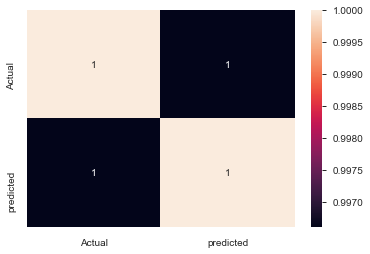

In [175]:
sns.heatmap(test_random[['Actual','predicted']].corr(),annot = True)

# Scatter plot
Model is showing high accuracy as we are getting straight line with our actual and predicted values

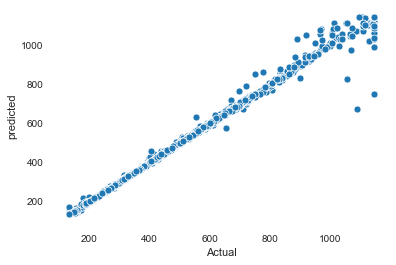

In [176]:
sns.scatterplot(test_random.Actual,test_random.predicted)

# Decile analysis
We can see that outputs are good for almost every observation

In [177]:
test_random['Deciles'] = pd.qcut(test_random.predicted,10,labels = False)

In [178]:
test_random.groupby('Deciles')[['Actual','predicted']].mean().sort_index(ascending = False).reset_index()

,Deciles,Actual,predicted
0,9,1068.411048,1067.031709
1,8,773.410643,769.076088
2,7,626.664667,623.988639
3,6,524.964267,525.549077
4,5,455.067200,456.160334
5,4,396.582333,396.860088
6,3,339.462333,339.538273
7,2,290.656333,290.540261
8,1,230.898800,231.317336
9,0,152.139240,152.381078


## Random Forest is doing best for this data set

In [179]:
feature_columns

['agecat_5',
 'agecat_6',
 'carcatvalue_1',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2spent',
 'card_2',
 'card_3',
 'cardspent',
 'carown_0',
 'creddebt',
 'gender_1',
 'inccat_3',
 'inccat_4',
 'jobcat_2',
 'othdebt',
 'reason_2',
 'retire_1']

# Random forest with pca

In [193]:
credit_new[feature_columns].shape

(5000, 19)

In [203]:
pcaf=credit_new[feature_columns]

In [181]:

from sklearn.decomposition import PCA

In [194]:
pc=PCA(n_components=19)
pca=pc.fit(credit_new[feature_columns])

In [195]:
sum(pca.explained_variance_ratio_)

0.9999999999999998

In [197]:
var_ratio={}
for n in range(2,18):
    pc=PCA(n_components=n)
    pca=pc.fit(credit_new[feature_columns])
    var_ratio[n]=sum(pca.explained_variance_ratio_)

In [198]:
var_ratio

{2: 0.9997017450954825,
 3: 0.999918080629391,
 4: 0.9999494581224884,
 5: 0.9999573178347931,
 6: 0.9999636127727737,
 7: 0.9999689069759443,
 8: 0.9999739971087862,
 9: 0.999978031889433,
 10: 0.9999816434338777,
 11: 0.9999850304149451,
 12: 0.9999881375046926,
 13: 0.9999911578403415,
 14: 0.9999933102379518,
 15: 0.9999953179437588,
 16: 0.9999966673911331,
 17: 0.9999979721645528}

In [206]:
pc=PCA(n_components=15)

In [204]:
p=pc.fit(pcaf)

In [207]:
pcaf.shape

(5000, 19)

In [209]:
p.explained_variance_

array([3.99137075e+04, 6.97870010e+03, 1.01475206e+01, 1.47180517e+00,
       3.68670799e-01, 2.95273142e-01, 2.48331824e-01, 2.38759700e-01,
       1.89257011e-01, 1.69404540e-01, 1.58871081e-01, 1.45742387e-01,
       1.41673065e-01, 1.00961218e-01, 9.41742470e-02])

In [210]:
np.sum(p.explained_variance_)

46906.17805728839

In [212]:
var_ratio

{2: 0.9997017450954825,
 3: 0.999918080629391,
 4: 0.9999494581224884,
 5: 0.9999573178347931,
 6: 0.9999636127727737,
 7: 0.9999689069759443,
 8: 0.9999739971087862,
 9: 0.999978031889433,
 10: 0.9999816434338777,
 11: 0.9999850304149451,
 12: 0.9999881375046926,
 13: 0.9999911578403415,
 14: 0.9999933102379518,
 15: 0.9999953179437588,
 16: 0.9999966673911331,
 17: 0.9999979721645528}

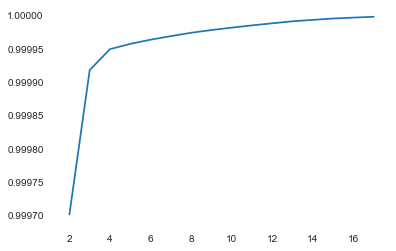

In [213]:
pd.Series(var_ratio).plot()

In [214]:
pcaf.shape

(5000, 19)

In [215]:
pc_final=PCA(n_components=15).fit(pcaf)

reduced_cr=pc_final.fit_transform(pcaf)

In [216]:
dd=pd.DataFrame(reduced_cr)

In [217]:
dd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-246.851352,16.037341,0.117984,0.100138,-0.473724,-0.070496,0.538876,-0.014910,-0.463229,-0.426694,-0.127100,0.175634,0.668392,-0.051279,-0.176642
1,-260.025925,-14.068161,-0.401700,0.348303,0.453791,-0.036784,-0.547222,-0.779490,-0.023225,-0.019895,0.104068,-0.719595,0.297681,-0.106144,-0.120939
2,-118.456959,77.688944,-0.493582,-0.362675,0.532164,0.546480,0.522180,-0.447590,0.414242,0.167232,0.091957,-0.716921,0.281208,-0.327546,-0.175392
3,-37.907134,-129.292218,-2.130946,-0.569101,0.966547,-0.036342,-0.509324,-0.706807,-0.059728,-0.151447,0.241910,-0.091085,0.079987,-0.311118,0.380156
4,-22.675933,119.796873,-3.398080,-0.225517,0.014175,0.274536,-0.422722,-0.756516,0.010473,0.149057,0.047644,0.010491,0.024017,0.874467,-0.167587


In [218]:
dd.shape

(5000, 15)

In [219]:
col_list=pcaf.columns

In [220]:
col_list

Index(['agecat_5', 'agecat_6', 'carcatvalue_1', 'carcatvalue_3', 'card2_2',
       'card2_3', 'card2spent', 'card_2', 'card_3', 'cardspent', 'carown_0',
       'creddebt', 'gender_1', 'inccat_3', 'inccat_4', 'jobcat_2', 'othdebt',
       'reason_2', 'retire_1'],
      dtype='object')

In [221]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' +str(i) for i in range(15)],index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14
agecat_5,0.000268,6.548399e-05,0.031179,0.000270,-0.008092,-0.341834,-0.044369,-0.056474,-0.167071,0.620377,-0.531841,1.901349e-01,-0.190697,-0.213018,-0.093300
agecat_6,-0.000170,-9.098445e-05,-0.004239,0.004585,0.001529,0.554324,0.014532,0.303092,0.386137,0.180079,0.058693,1.085439e-02,0.016870,-0.224071,-0.054527
carcatvalue_1,-0.000740,-4.054002e-05,-0.067500,-0.036849,0.035067,0.454349,0.108071,-0.424967,-0.473261,-0.171719,-0.174610,1.321113e-02,-0.058077,-0.149806,-0.137812
carcatvalue_3,0.000508,1.373522e-04,0.057875,0.020844,-0.010910,-0.052340,-0.020852,0.180772,-0.121332,0.348432,0.311791,-7.237873e-03,0.120377,0.057702,0.075737
card2_2,-0.000154,-9.256894e-05,0.003774,0.001416,-0.511735,0.020286,0.043715,-0.025665,-0.022119,0.011772,0.163650,-2.062625e-01,-0.660460,-0.174992,0.443550
card2_3,-0.000173,-1.250699e-04,-0.000408,-0.006051,0.535726,-0.022662,0.005082,0.041147,-0.020540,-0.129318,0.156155,6.233084e-01,-0.229162,-0.173083,0.443623
card2spent,0.400841,9.161398e-01,-0.003664,-0.000422,0.000101,0.000217,0.000314,-0.000066,0.000133,0.000083,-0.000012,-2.324589e-05,-0.000075,-0.000104,0.000278
card_2,-0.000264,-1.308814e-04,-0.005309,-0.011686,0.474341,-0.001428,-0.016061,0.016025,-0.026599,0.070256,-0.215718,-6.687498e-01,0.151194,-0.205230,0.457516
card_3,-0.000254,-1.817117e-07,-0.002334,0.008041,-0.464343,0.028808,0.089475,-0.028597,-0.010294,-0.047394,-0.215135,2.662053e-01,0.612848,-0.174396,0.498000
cardspent,0.916134,-4.008544e-01,-0.003833,-0.000209,0.000002,0.000428,0.000183,-0.000183,-0.000131,-0.000155,-0.000205,-1.158493e-07,-0.000007,-0.000145,0.000234


In [222]:
# Factor Analysis : variance explained by each component- 
pd.Series(pc_final.explained_variance_ratio_,index=['PC_'+ str(i) for i in range(15)])

PC_0     0.850922
PC_1     0.148779
PC_2     0.000216
PC_3     0.000031
PC_4     0.000008
PC_5     0.000006
PC_6     0.000005
PC_7     0.000005
PC_8     0.000004
PC_9     0.000004
PC_10    0.000003
PC_11    0.000003
PC_12    0.000003
PC_13    0.000002
PC_14    0.000002
dtype: float64

In [223]:
type(pca)

sklearn.decomposition._pca.PCA

In [187]:
# method : divide the data into training and testing
train, test = train_test_split(credit_new, test_size = 0.3, random_state = 123)

In [188]:
credit_new

,log_total_spend,agecat_5,agecat_6,carcatvalue_1,carcatvalue_3,card2_2,card2_3,card2spent,card_2,card_3,cardspent,carown_0,creddebt,gender_1,inccat_3,inccat_4,jobcat_2,othdebt,reason_2,retire_1
0,5.007029,0,0,1,0,0,0,67.800,0,1,91.3045,0,1.200909,1,0,0,0,2.240091,0,0
1,4.891146,0,0,1,0,0,0,34.940,1,0,91.3045,0,1.222020,0,0,0,1,1.567980,0,0
2,5.886021,0,1,1,0,0,0,175.750,1,0,184.2200,0,0.928620,1,0,0,1,2.536380,1,0
3,5.884464,0,0,1,0,0,1,18.420,1,0,340.9900,0,0.101088,0,0,0,1,1.117200,0,0
4,6.230147,0,0,1,0,0,0,252.730,0,0,255.1000,1,0.214659,0,0,0,1,0.287692,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.043288,0,1,0,1,0,1,419.447,0,0,782.3155,0,6.373010,0,0,0,0,7.745920,0,0
4996,5.903589,1,0,0,1,0,0,155.540,0,1,210.8100,0,3.336600,0,0,1,0,9.113400,0,0
4997,7.043288,0,1,0,1,1,0,419.447,0,0,782.3155,0,3.557520,0,0,1,0,8.106480,0,0
4998,6.623999,0,0,0,1,0,0,371.600,0,1,381.3500,0,5.021352,0,0,0,1,11.815981,0,0


In [189]:
x_pca

array([[-2.46851385e+02,  1.60373234e+01,  1.18581586e-01, ...,
         3.93465293e-01, -5.07434354e-01,  2.86993154e-01],
       [-2.60025799e+02, -1.40681078e+01, -3.88192222e-01, ...,
        -5.25313754e-01, -3.46964785e-01, -2.74867912e-01],
       [-1.18456843e+02,  7.76889874e+01, -4.82542455e-01, ...,
        -4.48434612e-01, -1.60774890e-01, -3.07812670e-01],
       ...,
       [ 5.27194331e+02,  6.12119895e+01,  2.62290070e+00, ...,
        -4.97692104e-01,  9.60925184e-02, -5.54926369e-02],
       [ 1.40696457e+02,  1.78113509e+02,  8.24589832e+00, ...,
         3.87743424e-01, -7.77266933e-01,  3.81253747e-02],
       [-5.51986199e+01,  8.96157688e+00, -1.32176493e-02, ...,
         3.17562838e-01, -1.00702786e+00,  7.93128205e-02]])

In [190]:
model_build_cum_evaluation(random_forest,x_pca,pre)

MAE: 0.013023979313834939
MSE train: 0.00010992607200004281
MSE test: 0.00093943938306765
RMSE: 0.030650275415853117
R2:  0.9969719301584169
Cross_val: 99.76866894569446


In [191]:
random_forest

RandomForestRegressor(n_jobs=-1)